#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем необходимые для работы библиотеки и инструменты:

In [34]:
# библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

# инструменты
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import time

# блокиратор предупреждений
import warnings
warnings.filterwarnings("ignore")

Загрузим исходные данные, столбец **'datetime'** зададим в качестве индекса и приведем его тип к datetime64:

In [35]:
data = pd.read_csv("/datasets/taxi.csv", parse_dates=[0], index_col=[0])
data.sort_index(inplace=True)
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Проверим данные на монотонность по индексу:

In [36]:
data.index.is_monotonic

True

Мы имеем данные по заказам такси за период с 2018-03-01 до 2018-08-31 с временным интервалом 10 мин, расположенные в хронологическом порядке. Проведем анализ этих данных.

## Анализ

Проведем ресемплирование данных с интервалом в 1 час, построим график суммарного количества заказов, применим скрользящее среднее с размером в одну неделю (24*7):

Text(0.5, 1.0, 'Изменение количества заказов такси')

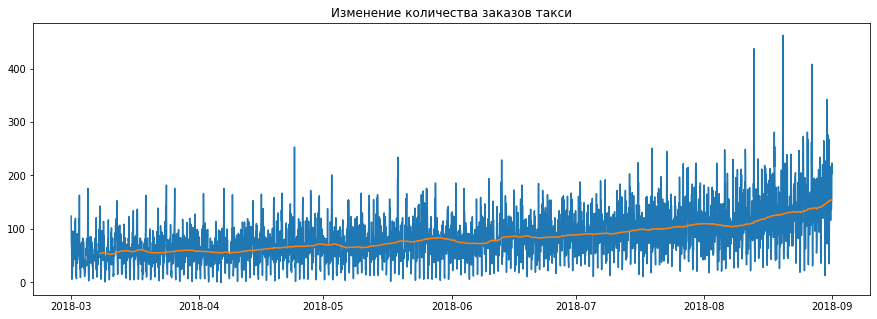

In [37]:
data = data.resample('1H').sum()
data['rolling_mean'] = data.rolling(24*7).mean()

plt.figure(figsize=(15, 5))
plt.plot(data, label="Actual values")
plt.title("Изменение количества заказов такси")

Исходя из полученного графика мы видим, что за наблюдаемый период происходит рост количества заказов, особенно сильно этот рост наблюдается за последний месяц.

Посмотрим на тренды и сезонность изучаемого временного ряда:

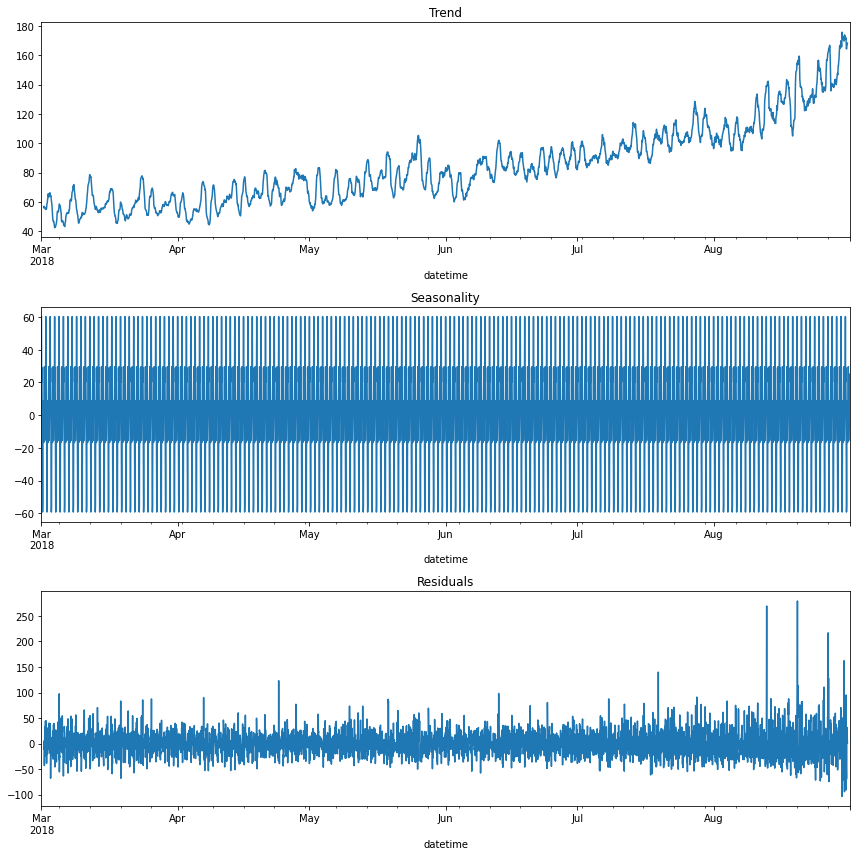

In [38]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(12, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

График тренда подтверждает выявленную ранее тенденцию непрерывного роста количества заказов. Колебания на графике сезонности показывают изменения в количестве заказов в пределах одного дня. Рассмотрим эти колебания детальнее по данным за одну рандомную неделю:

<AxesSubplot:title={'center':'Сезонность заказов в течение 7 дней'}, xlabel='datetime'>

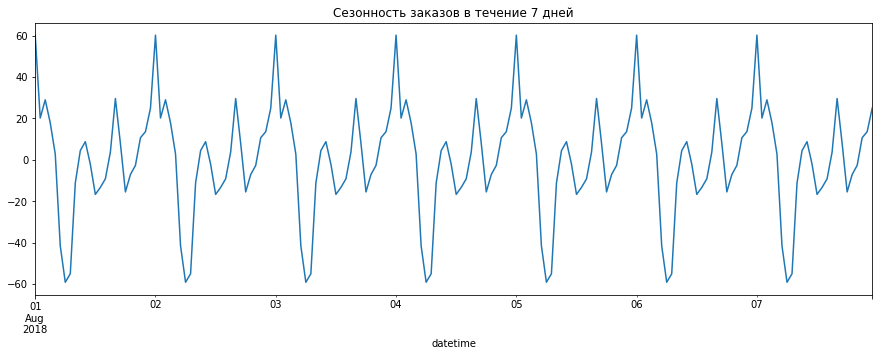

In [39]:
plt.figure(figsize=(15,5))
plt.title("Сезонность заказов в течение 7 дней")
decomposed.seasonal['2018-08-01':'2018-08-07'].plot(ax=plt.gca())

Сезонность в данном случае проявляется в изменениях количества заказов в течении суток: 
- пик активности приходится примерно на полночь, видимо это связано с окончанием работы общественного транспорта и пассажиры, задержавшиеся в гостях или в местах отдыха и развлечений, вынуждены пользоваться услугами такси
- глубокой ночью наблюдается минимум активности, что очевидно - люди спят
- утром и ранним вечером также наблюдается рост количества заказов - видимо многие пассажиры выбирают такси для ежедневных маршрутов дом - работа - дом

Как мы отмечали выше, временной ряд подвержен тренду. Проверим по критерию Дики-Фуллера, насколько сильно влияние тренда на изучаемый временной ряд и можно ли его считать стационарным:

In [40]:
print('Значение p-value по критерию Дики-Фуллера:', round(sm.tsa.stattools.adfuller(data['num_orders'])[1], 3))

Значение p-value по критерию Дики-Фуллера: 0.029


Полученное значение P не превышает критической отметки в 5%, влияние тренда незначительно, можно принять временной ряд за стационарный. 

В итоге: изучаемый временной ряд монотонен и стационарен, пропусков в данных нет, предобработки данных не требуется. Можно приступить к обучению моделей.

## Обучение

Создадим признаки для горизонта прогнозирования в 1 час - 'hour', 'day', 'day_of_week'. Также добавим признаки отстающих значений и скользящего среднего:

In [41]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = round(data['num_orders'].shift().rolling(rolling_mean_size).mean())
    
make_features(data, 2, 24)
data.sample(5)

,num_orders,rolling_mean,hour,day,day_of_week,lag_1,lag_2
datetime,,,,,,,
2018-03-01 20:00:00,61,NaN,20,1,3,45.0,73.0
2018-03-13 03:00:00,63,64.0,3,13,1,58.0,88.0
2018-03-03 05:00:00,15,64.0,5,3,5,44.0,64.0
2018-06-14 22:00:00,79,82.0,22,14,3,99.0,109.0
2018-07-15 23:00:00,100,92.0,23,15,6,98.0,85.0


Отделим от данных тестовую выборку размером 10% от изначальной не перемешивая данные:

In [42]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
# проверим корректность деления
print("Диапазон обучающей выборки: с", train.index.min(), "до", train.index.max())
print("Диапазон тестовой  выборки: с", test.index.min(), "до", test.index.max())

Диапазон обучающей выборки: с 2018-03-02 00:00:00 до 2018-08-13 13:00:00
Диапазон тестовой  выборки: с 2018-08-13 14:00:00 до 2018-08-31 23:00:00


Создадим обучающие и целевой признаки:

In [43]:
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)
target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

Метрикой качества работы моделей примем RMSE, напишем функцию для её вычисления:

In [44]:
def rmse_score (target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse
scorer = make_scorer(rmse_score, greater_is_better=False)

Приступим к обучению моделей, для подбора оптимальных гиперпараметров применим кросс-валидацию и используем методы TimeSeriesSplit и RandomizedSearchCV:

In [45]:
tscv = TimeSeriesSplit(n_splits=8)

### LinearRegression

In [46]:
%%time

model = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}

grid = RandomizedSearchCV(model, parameters, cv=tscv, scoring=scorer, verbose=5, n_jobs=-1)
grid.fit(features_train, target_train)
print()
print(f"RMSE линейной регрессии: {abs(grid.best_score_):.2f}")
print(f"Оптимальные гиперпараметры для линейной регрессии: {grid.best_params_}")
print()

Fitting 8 folds for each of 4 candidates, totalling 32 fits
[CV 1/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 2/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 3/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 4/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 5/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 6/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 7/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 8/8] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 1/8] END ............fit_intercept=True, normalize=False; total time=   0.0s
[CV 2/8] END ............fit_intercept=True, normalize=False; total time=   0.0s
[CV 3/8] END ............fit_intercept=True, normalize=False; total time=   0.0s
[CV 4/8] END ............fit_intercept=True, norm

### RandomForestRegressor

In [47]:
%%time

model = RandomForestRegressor(random_state=12345)
parameters = {'n_estimators': range(30, 151, 10), 'max_depth': range(1,15)}

grid = RandomizedSearchCV(model, parameters, cv=tscv, scoring=scorer, verbose=5, n_jobs=-1)
grid.fit(features_train, target_train)

print()
print(f"RMSE случайного леса: {abs(grid.best_score_):.2f}")
print(f"Оптимальные гиперпараметры для случайного леса: {grid.best_params_}")
print()

Fitting 8 folds for each of 10 candidates, totalling 80 fits
[CV 1/8] END ...................max_depth=9, n_estimators=80; total time=   0.4s
[CV 2/8] END ...................max_depth=9, n_estimators=80; total time=   0.5s
[CV 3/8] END ...................max_depth=9, n_estimators=80; total time=   0.4s
[CV 4/8] END ...................max_depth=9, n_estimators=80; total time=   0.3s
[CV 5/8] END ...................max_depth=9, n_estimators=80; total time=   0.3s
[CV 6/8] END ...................max_depth=9, n_estimators=80; total time=   0.4s
[CV 7/8] END ...................max_depth=9, n_estimators=80; total time=   0.5s
[CV 8/8] END ...................max_depth=9, n_estimators=80; total time=   0.5s
[CV 1/8] END ..................max_depth=8, n_estimators=150; total time=   0.3s
[CV 2/8] END ..................max_depth=8, n_estimators=150; total time=   0.4s
[CV 3/8] END ..................max_depth=8, n_estimators=150; total time=   0.4s
[CV 4/8] END ..................max_depth=8, n_es

### LightGBM

In [48]:
%%time

model = LGBMRegressor(random_state=12345)   
parameters = {'n_estimators': [100, 500],
              'num_leaves': [21, 31],
              'learning_rate':[0.01]}
# для экономии времени сократил изначальные варианты возможных гиперпараметров

grid = RandomizedSearchCV(model, parameters, cv=tscv, verbose=5, scoring=scorer)
grid.fit(features_train, target_train)

print()
print(f"RMSE LightGBM: {abs(grid.best_score_):.2f}")
print(f"Оптимальные гиперпараметры для LightGBM: {grid.best_params_}")
print()

Fitting 8 folds for each of 4 candidates, totalling 32 fits
[CV 1/8] END learning_rate=0.01, n_estimators=100, num_leaves=21; total time=  14.2s
[CV 2/8] END learning_rate=0.01, n_estimators=100, num_leaves=21; total time=  13.1s
[CV 3/8] END learning_rate=0.01, n_estimators=100, num_leaves=21; total time=  27.9s
[CV 4/8] END learning_rate=0.01, n_estimators=100, num_leaves=21; total time=  25.0s
[CV 5/8] END learning_rate=0.01, n_estimators=100, num_leaves=21; total time=  40.2s
[CV 6/8] END learning_rate=0.01, n_estimators=100, num_leaves=21; total time=  26.4s
[CV 7/8] END learning_rate=0.01, n_estimators=100, num_leaves=21; total time=  29.2s
[CV 8/8] END learning_rate=0.01, n_estimators=100, num_leaves=21; total time=  23.1s
[CV 1/8] END learning_rate=0.01, n_estimators=100, num_leaves=31; total time=  12.5s
[CV 2/8] END learning_rate=0.01, n_estimators=100, num_leaves=31; total time=  15.9s
[CV 3/8] END learning_rate=0.01, n_estimators=100, num_leaves=31; total time=  31.1s
[CV 4

### CatBoost

In [49]:
%%time

model = CatBoostRegressor(loss_function="RMSE")
parameters = {'learning_rate': [0.1, 0.2, 0.5], 'iterations': [150, 500]}

grid = RandomizedSearchCV(model, parameters, cv=tscv, verbose=5, scoring=scorer)
grid.fit(features_train, target_train)

print()
print(f"RMSE CatBoost: {abs(grid.best_score_):.2f}")
print(f"Оптимальные гиперпараметры для CatBoost: {grid.best_params_}")
print()

Fitting 8 folds for each of 6 candidates, totalling 48 fits


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 27.9402430	total: 732us	remaining: 109ms
1:	learn: 26.8396745	total: 1.25ms	remaining: 92.3ms
2:	learn: 26.0936964	total: 1.62ms	remaining: 79.4ms
3:	learn: 25.1197279	total: 1.96ms	remaining: 71.7ms
4:	learn: 24.2109506	total: 2.44ms	remaining: 70.7ms
5:	learn: 23.3527580	total: 2.78ms	remaining: 66.7ms
6:	learn: 22.7823995	total: 3.12ms	remaining: 63.7ms
7:	learn: 22.0422286	total: 3.47ms	remaining: 61.5ms
8:	learn: 21.3931104	total: 3.82ms	remaining: 59.8ms
9:	learn: 20.8459651	total: 4.15ms	remaining: 58.1ms
10:	learn: 20.3532152	total: 4.53ms	remaining: 57.3ms
11:	learn: 19.9452070	total: 4.91ms	remaining: 56.5ms
12:	learn: 19.6233852	total: 5.25ms	remaining: 55.3ms
13:	learn: 19.3067766	total: 5.62ms	remaining: 54.6ms
14:	learn: 19.0251789	total: 5.99ms	remaining: 53.9ms
15:	learn: 18.6686657	total: 6.38ms	remaining: 53.5ms
16:	learn: 18.4070690	total: 6.93ms	remaining: 54.2ms
17:	learn: 18.1229075	total: 7.53ms	remaining: 55.2ms
18:	learn: 17.8611962	total: 7.96ms	rema

[CV 2/8] END ..............iterations=150, learning_rate=0.1; total time=   0.6s
0:	learn: 29.3790554	total: 767us	remaining: 114ms
1:	learn: 28.2933733	total: 1.51ms	remaining: 112ms
2:	learn: 27.5219925	total: 2.08ms	remaining: 102ms
3:	learn: 26.6860243	total: 2.64ms	remaining: 96.5ms
4:	learn: 25.8386650	total: 3.23ms	remaining: 93.8ms
5:	learn: 25.2575463	total: 3.81ms	remaining: 91.4ms
6:	learn: 24.6084470	total: 4.39ms	remaining: 89.8ms
7:	learn: 23.9955157	total: 4.91ms	remaining: 87.2ms
8:	learn: 23.5829187	total: 5.41ms	remaining: 84.7ms
9:	learn: 23.0593362	total: 5.96ms	remaining: 83.4ms
10:	learn: 22.6744749	total: 6.46ms	remaining: 81.6ms
11:	learn: 22.3434083	total: 6.99ms	remaining: 80.4ms
12:	learn: 22.0705715	total: 7.5ms	remaining: 79.1ms
13:	learn: 21.8166385	total: 8.03ms	remaining: 78ms
14:	learn: 21.6382211	total: 8.66ms	remaining: 77.9ms
15:	learn: 21.3642640	total: 9.35ms	remaining: 78.3ms
16:	learn: 21.2035632	total: 10.1ms	remaining: 78.8ms
17:	learn: 21.0301

0:	learn: 30.1123224	total: 811us	remaining: 121ms
1:	learn: 29.0895209	total: 1.59ms	remaining: 118ms
2:	learn: 28.3042850	total: 2.29ms	remaining: 112ms
3:	learn: 27.6259734	total: 3.26ms	remaining: 119ms
4:	learn: 26.7250335	total: 4.03ms	remaining: 117ms
5:	learn: 25.9815986	total: 4.65ms	remaining: 112ms
6:	learn: 25.4803957	total: 5.55ms	remaining: 113ms
7:	learn: 24.8564702	total: 6.21ms	remaining: 110ms
8:	learn: 24.3251829	total: 7.04ms	remaining: 110ms
9:	learn: 23.8019839	total: 7.92ms	remaining: 111ms
10:	learn: 23.4694074	total: 8.77ms	remaining: 111ms
11:	learn: 23.0892450	total: 9.36ms	remaining: 108ms
12:	learn: 22.7632271	total: 10ms	remaining: 106ms
13:	learn: 22.5262543	total: 10.9ms	remaining: 106ms
14:	learn: 22.2573229	total: 11.7ms	remaining: 105ms
15:	learn: 22.0306457	total: 12.6ms	remaining: 105ms
16:	learn: 21.8784050	total: 13.2ms	remaining: 103ms
17:	learn: 21.7201524	total: 13.8ms	remaining: 101ms
18:	learn: 21.5177350	total: 14.4ms	remaining: 99.4ms
19:	l

[CV 5/8] END ..............iterations=150, learning_rate=0.1; total time=   0.7s
0:	learn: 32.0128986	total: 1.01ms	remaining: 151ms
1:	learn: 30.8027122	total: 1.9ms	remaining: 141ms
2:	learn: 29.6513226	total: 2.68ms	remaining: 131ms
3:	learn: 28.8720264	total: 3.46ms	remaining: 126ms
4:	learn: 28.1995002	total: 4.25ms	remaining: 123ms
5:	learn: 27.4948658	total: 4.99ms	remaining: 120ms
6:	learn: 26.7812248	total: 5.68ms	remaining: 116ms
7:	learn: 26.1961462	total: 6.44ms	remaining: 114ms
8:	learn: 25.7226145	total: 7.12ms	remaining: 112ms
9:	learn: 25.2309552	total: 7.85ms	remaining: 110ms
10:	learn: 24.7970239	total: 8.56ms	remaining: 108ms
11:	learn: 24.4827625	total: 9.3ms	remaining: 107ms
12:	learn: 24.1164320	total: 10ms	remaining: 105ms
13:	learn: 23.8003580	total: 10.7ms	remaining: 104ms
14:	learn: 23.5588884	total: 11.4ms	remaining: 103ms
15:	learn: 23.3098688	total: 12.1ms	remaining: 101ms
16:	learn: 23.0720106	total: 12.8ms	remaining: 100ms
17:	learn: 22.9093554	total: 13.

0:	learn: 32.5332804	total: 1.02ms	remaining: 153ms
1:	learn: 31.2610415	total: 2.38ms	remaining: 176ms
2:	learn: 30.0745004	total: 3.22ms	remaining: 158ms
3:	learn: 29.0951045	total: 4.03ms	remaining: 147ms
4:	learn: 28.4329845	total: 4.88ms	remaining: 142ms
5:	learn: 27.8002183	total: 5.64ms	remaining: 135ms
6:	learn: 27.2277351	total: 6.38ms	remaining: 130ms
7:	learn: 26.5584193	total: 7.14ms	remaining: 127ms
8:	learn: 25.9661662	total: 7.95ms	remaining: 125ms
9:	learn: 25.5031769	total: 8.75ms	remaining: 122ms
10:	learn: 25.1219420	total: 9.48ms	remaining: 120ms
11:	learn: 24.7802034	total: 10.2ms	remaining: 118ms
12:	learn: 24.5240122	total: 11ms	remaining: 116ms
13:	learn: 24.2507463	total: 11.7ms	remaining: 114ms
14:	learn: 24.0445576	total: 12.5ms	remaining: 112ms
15:	learn: 23.8728209	total: 13.2ms	remaining: 111ms
16:	learn: 23.6044660	total: 14ms	remaining: 110ms
17:	learn: 23.4380129	total: 14.8ms	remaining: 109ms
18:	learn: 23.2339834	total: 15.6ms	remaining: 107ms
19:	lea

[CV 8/8] END ..............iterations=150, learning_rate=0.1; total time=   0.6s
0:	learn: 26.7181065	total: 446us	remaining: 66.6ms
1:	learn: 24.7364681	total: 1.03ms	remaining: 76ms
2:	learn: 23.5159800	total: 1.6ms	remaining: 78.5ms
3:	learn: 22.0893393	total: 2.04ms	remaining: 74.7ms
4:	learn: 20.8863084	total: 2.47ms	remaining: 71.5ms
5:	learn: 19.9167888	total: 2.82ms	remaining: 67.7ms
6:	learn: 19.2771955	total: 3.22ms	remaining: 65.8ms
7:	learn: 18.6109679	total: 3.63ms	remaining: 64.4ms
8:	learn: 18.1137289	total: 4.02ms	remaining: 63ms
9:	learn: 17.6560772	total: 4.43ms	remaining: 62.1ms
10:	learn: 17.3573911	total: 4.85ms	remaining: 61.3ms
11:	learn: 17.0893801	total: 5.3ms	remaining: 61ms
12:	learn: 16.8433266	total: 5.7ms	remaining: 60ms
13:	learn: 16.5849511	total: 6.11ms	remaining: 59.4ms
14:	learn: 16.4115734	total: 6.53ms	remaining: 58.7ms
15:	learn: 16.2377514	total: 6.93ms	remaining: 58ms
16:	learn: 16.0794842	total: 7.36ms	remaining: 57.6ms
17:	learn: 15.9432438	tot

[CV 2/8] END ..............iterations=150, learning_rate=0.2; total time=   0.6s
0:	learn: 28.3224605	total: 614us	remaining: 91.6ms
1:	learn: 26.6705912	total: 1.2ms	remaining: 88.9ms
2:	learn: 25.4488251	total: 1.84ms	remaining: 90.3ms
3:	learn: 24.3501680	total: 2.46ms	remaining: 89.8ms
4:	learn: 23.2092240	total: 3.03ms	remaining: 88ms
5:	learn: 22.3695983	total: 3.62ms	remaining: 86.8ms
6:	learn: 21.8840697	total: 4.18ms	remaining: 85.5ms
7:	learn: 21.3707568	total: 4.77ms	remaining: 84.7ms
8:	learn: 20.9020568	total: 5.38ms	remaining: 84.3ms
9:	learn: 20.6617328	total: 5.95ms	remaining: 83.2ms
10:	learn: 20.3458963	total: 6.54ms	remaining: 82.6ms
11:	learn: 20.1212961	total: 7.12ms	remaining: 81.9ms
12:	learn: 19.8703143	total: 7.72ms	remaining: 81.4ms
13:	learn: 19.6750978	total: 8.32ms	remaining: 80.9ms
14:	learn: 19.5055134	total: 8.88ms	remaining: 79.9ms
15:	learn: 19.2482191	total: 9.45ms	remaining: 79.1ms
16:	learn: 19.1241271	total: 10ms	remaining: 78.3ms
17:	learn: 18.852

0:	learn: 28.8928705	total: 964us	remaining: 144ms
1:	learn: 26.9409133	total: 1.7ms	remaining: 126ms
2:	learn: 25.7916747	total: 2.31ms	remaining: 113ms
3:	learn: 24.8287582	total: 2.91ms	remaining: 106ms
4:	learn: 23.9612850	total: 3.54ms	remaining: 103ms
5:	learn: 23.2362133	total: 4.12ms	remaining: 98.8ms
6:	learn: 22.7922643	total: 4.75ms	remaining: 97ms
7:	learn: 22.3230021	total: 5.33ms	remaining: 94.5ms
8:	learn: 21.8728641	total: 5.89ms	remaining: 92.4ms
9:	learn: 21.4238854	total: 6.45ms	remaining: 90.3ms
10:	learn: 21.0850402	total: 7.04ms	remaining: 89ms
11:	learn: 20.8840435	total: 7.65ms	remaining: 88ms
12:	learn: 20.7455166	total: 8.23ms	remaining: 86.8ms
13:	learn: 20.6285319	total: 8.8ms	remaining: 85.5ms
14:	learn: 20.4169446	total: 9.6ms	remaining: 86.4ms
15:	learn: 20.2495710	total: 10.2ms	remaining: 85.7ms
16:	learn: 20.1545810	total: 10.8ms	remaining: 84.5ms
17:	learn: 20.0987716	total: 11.4ms	remaining: 83.4ms
18:	learn: 19.9679330	total: 12ms	remaining: 82.4ms
1

[CV 5/8] END ..............iterations=150, learning_rate=0.2; total time=   0.7s
0:	learn: 30.7355967	total: 1.01ms	remaining: 151ms
1:	learn: 28.6609692	total: 2.17ms	remaining: 161ms
2:	learn: 27.4164036	total: 3.23ms	remaining: 158ms
3:	learn: 26.4423842	total: 4.19ms	remaining: 153ms
4:	learn: 25.3254964	total: 5.08ms	remaining: 147ms
5:	learn: 24.5211764	total: 5.9ms	remaining: 142ms
6:	learn: 24.0372440	total: 6.74ms	remaining: 138ms
7:	learn: 23.5148124	total: 7.52ms	remaining: 134ms
8:	learn: 23.1556541	total: 8.36ms	remaining: 131ms
9:	learn: 22.7921233	total: 9.26ms	remaining: 130ms
10:	learn: 22.5671137	total: 10.1ms	remaining: 127ms
11:	learn: 22.3494844	total: 11ms	remaining: 126ms
12:	learn: 22.0827420	total: 11.8ms	remaining: 124ms
13:	learn: 21.9808738	total: 12.6ms	remaining: 123ms
14:	learn: 21.8855129	total: 13.4ms	remaining: 121ms
15:	learn: 21.7333045	total: 14.3ms	remaining: 120ms
16:	learn: 21.4725287	total: 15.1ms	remaining: 118ms
17:	learn: 21.3755005	total: 15

[CV 7/8] END ..............iterations=150, learning_rate=0.2; total time=   0.7s
0:	learn: 32.4280105	total: 1.25ms	remaining: 186ms
1:	learn: 30.7278021	total: 2.52ms	remaining: 187ms
2:	learn: 28.8082116	total: 3.83ms	remaining: 187ms
3:	learn: 27.3913228	total: 4.76ms	remaining: 174ms
4:	learn: 26.5090829	total: 5.72ms	remaining: 166ms
5:	learn: 25.8937655	total: 6.68ms	remaining: 160ms
6:	learn: 25.4429813	total: 7.69ms	remaining: 157ms
7:	learn: 24.7786040	total: 8.6ms	remaining: 153ms
8:	learn: 24.3436070	total: 9.63ms	remaining: 151ms
9:	learn: 23.9218631	total: 10.6ms	remaining: 148ms
10:	learn: 23.6177853	total: 11.6ms	remaining: 146ms
11:	learn: 23.4471269	total: 12.6ms	remaining: 145ms
12:	learn: 23.2620768	total: 13.6ms	remaining: 143ms
13:	learn: 22.9550625	total: 14.6ms	remaining: 142ms
14:	learn: 22.8207015	total: 15.6ms	remaining: 140ms
15:	learn: 22.6874310	total: 16.7ms	remaining: 140ms
16:	learn: 22.5698630	total: 17.7ms	remaining: 138ms
17:	learn: 22.4307123	total: 

[CV 1/8] END ..............iterations=150, learning_rate=0.5; total time=   0.6s
0:	learn: 24.1233496	total: 691us	remaining: 103ms
1:	learn: 21.1932095	total: 1.46ms	remaining: 108ms
2:	learn: 20.0169650	total: 2.11ms	remaining: 104ms
3:	learn: 19.2866650	total: 2.66ms	remaining: 97.1ms
4:	learn: 18.7447001	total: 3.27ms	remaining: 94.7ms
5:	learn: 18.3463855	total: 3.85ms	remaining: 92.3ms
6:	learn: 18.0093768	total: 4.44ms	remaining: 90.8ms
7:	learn: 17.4092706	total: 4.99ms	remaining: 88.5ms
8:	learn: 17.1587284	total: 5.57ms	remaining: 87.2ms
9:	learn: 16.8460306	total: 6.09ms	remaining: 85.3ms
10:	learn: 16.5631207	total: 6.72ms	remaining: 85ms
11:	learn: 16.4796551	total: 7.29ms	remaining: 83.9ms
12:	learn: 16.2702128	total: 7.89ms	remaining: 83.2ms
13:	learn: 15.8994540	total: 8.46ms	remaining: 82.1ms
14:	learn: 15.7638677	total: 9.11ms	remaining: 82ms
15:	learn: 15.5759871	total: 9.7ms	remaining: 81.2ms
16:	learn: 15.1860347	total: 10.3ms	remaining: 80.9ms
17:	learn: 14.936644

[CV 3/8] END ..............iterations=150, learning_rate=0.5; total time=   0.7s
0:	learn: 25.8124945	total: 799us	remaining: 119ms
1:	learn: 23.2221199	total: 1.59ms	remaining: 117ms
2:	learn: 21.9830590	total: 2.35ms	remaining: 115ms
3:	learn: 21.1846570	total: 3.01ms	remaining: 110ms
4:	learn: 20.6830101	total: 3.65ms	remaining: 106ms
5:	learn: 20.3318940	total: 4.34ms	remaining: 104ms
6:	learn: 20.1094880	total: 5.14ms	remaining: 105ms
7:	learn: 19.7236952	total: 5.79ms	remaining: 103ms
8:	learn: 19.2214044	total: 6.4ms	remaining: 100ms
9:	learn: 18.6695318	total: 7.05ms	remaining: 98.7ms
10:	learn: 18.5695100	total: 7.64ms	remaining: 96.6ms
11:	learn: 18.4903287	total: 8.3ms	remaining: 95.5ms
12:	learn: 18.3090511	total: 8.92ms	remaining: 94ms
13:	learn: 18.0937507	total: 9.54ms	remaining: 92.7ms
14:	learn: 17.7917384	total: 10.2ms	remaining: 91.8ms
15:	learn: 17.6520840	total: 11ms	remaining: 92.2ms
16:	learn: 17.3058140	total: 11.7ms	remaining: 91.4ms
17:	learn: 17.0054262	total

[CV 5/8] END ..............iterations=150, learning_rate=0.5; total time=   0.6s
0:	learn: 27.5368384	total: 889us	remaining: 133ms
1:	learn: 24.3998174	total: 1.76ms	remaining: 130ms
2:	learn: 23.2393171	total: 2.63ms	remaining: 129ms
3:	learn: 22.3131534	total: 3.38ms	remaining: 124ms
4:	learn: 21.7513600	total: 4.1ms	remaining: 119ms
5:	learn: 21.3475255	total: 5.11ms	remaining: 123ms
6:	learn: 21.1469015	total: 5.86ms	remaining: 120ms
7:	learn: 20.8683271	total: 6.63ms	remaining: 118ms
8:	learn: 20.5437220	total: 7.34ms	remaining: 115ms
9:	learn: 20.3587099	total: 8.11ms	remaining: 114ms
10:	learn: 20.1720538	total: 8.8ms	remaining: 111ms
11:	learn: 20.0951320	total: 9.52ms	remaining: 109ms
12:	learn: 19.8740863	total: 10.2ms	remaining: 108ms
13:	learn: 19.6414138	total: 11.1ms	remaining: 107ms
14:	learn: 19.4818930	total: 11.7ms	remaining: 106ms
15:	learn: 19.2361454	total: 12.5ms	remaining: 105ms
16:	learn: 19.0038479	total: 13.3ms	remaining: 104ms
17:	learn: 18.7716291	total: 14

0:	learn: 27.2160299	total: 1.07ms	remaining: 160ms
1:	learn: 24.6026032	total: 1.95ms	remaining: 144ms
2:	learn: 23.3687435	total: 2.78ms	remaining: 136ms
3:	learn: 22.7876518	total: 3.65ms	remaining: 133ms
4:	learn: 21.9848523	total: 4.5ms	remaining: 130ms
5:	learn: 21.5490183	total: 5.28ms	remaining: 127ms
6:	learn: 21.3223396	total: 5.99ms	remaining: 122ms
7:	learn: 20.8855310	total: 6.79ms	remaining: 121ms
8:	learn: 20.7199536	total: 7.52ms	remaining: 118ms
9:	learn: 20.5432400	total: 8.26ms	remaining: 116ms
10:	learn: 20.3935558	total: 8.97ms	remaining: 113ms
11:	learn: 20.2190027	total: 9.78ms	remaining: 113ms
12:	learn: 20.1488417	total: 10.6ms	remaining: 111ms
13:	learn: 19.8267426	total: 11.3ms	remaining: 110ms
14:	learn: 19.6719636	total: 12.1ms	remaining: 109ms
15:	learn: 19.4765239	total: 13ms	remaining: 109ms
16:	learn: 19.4257036	total: 13.7ms	remaining: 107ms
17:	learn: 19.3035510	total: 14.4ms	remaining: 106ms
18:	learn: 19.1165912	total: 15.2ms	remaining: 105ms
19:	le

[CV 8/8] END ..............iterations=150, learning_rate=0.5; total time=   0.9s
0:	learn: 27.9402430	total: 485us	remaining: 242ms
1:	learn: 26.8396745	total: 1ms	remaining: 250ms
2:	learn: 26.0936964	total: 1.41ms	remaining: 234ms
3:	learn: 25.1197279	total: 1.77ms	remaining: 220ms
4:	learn: 24.2109506	total: 2.11ms	remaining: 209ms
5:	learn: 23.3527580	total: 2.47ms	remaining: 203ms
6:	learn: 22.7823995	total: 2.79ms	remaining: 197ms
7:	learn: 22.0422286	total: 3.15ms	remaining: 194ms
8:	learn: 21.3931104	total: 3.48ms	remaining: 190ms
9:	learn: 20.8459651	total: 3.86ms	remaining: 189ms
10:	learn: 20.3532152	total: 4.25ms	remaining: 189ms
11:	learn: 19.9452070	total: 4.62ms	remaining: 188ms
12:	learn: 19.6233852	total: 4.94ms	remaining: 185ms
13:	learn: 19.3067766	total: 5.28ms	remaining: 183ms
14:	learn: 19.0251789	total: 5.6ms	remaining: 181ms
15:	learn: 18.6686657	total: 5.95ms	remaining: 180ms
16:	learn: 18.4070690	total: 6.3ms	remaining: 179ms
17:	learn: 18.1229075	total: 6.75m

299:	learn: 5.5283997	total: 131ms	remaining: 87.2ms
300:	learn: 5.5277027	total: 131ms	remaining: 86.9ms
301:	learn: 5.5047124	total: 132ms	remaining: 86.6ms
302:	learn: 5.4843284	total: 132ms	remaining: 86.1ms
303:	learn: 5.4783841	total: 133ms	remaining: 85.6ms
304:	learn: 5.4687543	total: 133ms	remaining: 85.1ms
305:	learn: 5.4625547	total: 134ms	remaining: 84.7ms
306:	learn: 5.4397836	total: 134ms	remaining: 84.2ms
307:	learn: 5.4086808	total: 134ms	remaining: 83.7ms
308:	learn: 5.4005595	total: 135ms	remaining: 83.2ms
309:	learn: 5.3698565	total: 135ms	remaining: 82.8ms
310:	learn: 5.3590469	total: 135ms	remaining: 82.3ms
311:	learn: 5.3459325	total: 136ms	remaining: 81.8ms
312:	learn: 5.3295426	total: 136ms	remaining: 81.3ms
313:	learn: 5.3132602	total: 136ms	remaining: 80.8ms
314:	learn: 5.3061761	total: 137ms	remaining: 80.3ms
315:	learn: 5.2882739	total: 137ms	remaining: 79.8ms
316:	learn: 5.2680396	total: 138ms	remaining: 79.4ms
317:	learn: 5.2609383	total: 138ms	remaining: 

[CV 1/8] END ..............iterations=500, learning_rate=0.1; total time=   0.8s
0:	learn: 28.2502737	total: 787us	remaining: 393ms
1:	learn: 27.1328508	total: 1.5ms	remaining: 373ms
2:	learn: 26.4822478	total: 2.26ms	remaining: 374ms
3:	learn: 25.5510996	total: 2.99ms	remaining: 371ms
4:	learn: 24.6675469	total: 3.69ms	remaining: 365ms
5:	learn: 23.9222726	total: 4.25ms	remaining: 350ms
6:	learn: 23.4727305	total: 4.71ms	remaining: 332ms
7:	learn: 22.8709904	total: 5.32ms	remaining: 327ms
8:	learn: 22.4110801	total: 5.85ms	remaining: 319ms
9:	learn: 22.0336253	total: 6.39ms	remaining: 313ms
10:	learn: 21.5551045	total: 6.86ms	remaining: 305ms
11:	learn: 21.2489112	total: 7.37ms	remaining: 300ms
12:	learn: 21.0053198	total: 7.88ms	remaining: 295ms
13:	learn: 20.7366654	total: 8.46ms	remaining: 294ms
14:	learn: 20.4925609	total: 8.97ms	remaining: 290ms
15:	learn: 20.2947576	total: 9.41ms	remaining: 285ms
16:	learn: 20.0102605	total: 9.92ms	remaining: 282ms
17:	learn: 19.8510896	total: 1

199:	learn: 10.9017721	total: 114ms	remaining: 170ms
200:	learn: 10.8878721	total: 114ms	remaining: 170ms
201:	learn: 10.8535677	total: 115ms	remaining: 169ms
202:	learn: 10.8176959	total: 115ms	remaining: 169ms
203:	learn: 10.7948580	total: 116ms	remaining: 168ms
204:	learn: 10.7609933	total: 116ms	remaining: 167ms
205:	learn: 10.7384325	total: 117ms	remaining: 166ms
206:	learn: 10.7156695	total: 117ms	remaining: 166ms
207:	learn: 10.7111516	total: 118ms	remaining: 165ms
208:	learn: 10.6848390	total: 118ms	remaining: 164ms
209:	learn: 10.6637123	total: 118ms	remaining: 164ms
210:	learn: 10.6496609	total: 119ms	remaining: 163ms
211:	learn: 10.5993567	total: 119ms	remaining: 162ms
212:	learn: 10.5765650	total: 120ms	remaining: 161ms
213:	learn: 10.5495226	total: 120ms	remaining: 161ms
214:	learn: 10.5299103	total: 121ms	remaining: 160ms
215:	learn: 10.5198287	total: 121ms	remaining: 159ms
216:	learn: 10.5062414	total: 122ms	remaining: 159ms
217:	learn: 10.4831002	total: 122ms	remaining:

415:	learn: 7.1136967	total: 236ms	remaining: 47.7ms
416:	learn: 7.0823428	total: 237ms	remaining: 47.1ms
417:	learn: 7.0664077	total: 237ms	remaining: 46.6ms
418:	learn: 7.0616067	total: 238ms	remaining: 46ms
419:	learn: 7.0540617	total: 238ms	remaining: 45.4ms
420:	learn: 7.0344182	total: 239ms	remaining: 44.8ms
421:	learn: 7.0246888	total: 239ms	remaining: 44.3ms
422:	learn: 7.0156211	total: 240ms	remaining: 43.7ms
423:	learn: 7.0072702	total: 240ms	remaining: 43.1ms
424:	learn: 6.9905908	total: 241ms	remaining: 42.5ms
425:	learn: 6.9788212	total: 241ms	remaining: 41.9ms
426:	learn: 6.9644219	total: 242ms	remaining: 41.3ms
427:	learn: 6.9598636	total: 242ms	remaining: 40.8ms
428:	learn: 6.9506219	total: 243ms	remaining: 40.2ms
429:	learn: 6.9362892	total: 243ms	remaining: 39.6ms
430:	learn: 6.9276336	total: 244ms	remaining: 39ms
431:	learn: 6.9221369	total: 244ms	remaining: 38.5ms
432:	learn: 6.9024815	total: 245ms	remaining: 37.9ms
433:	learn: 6.8959434	total: 245ms	remaining: 37.3

215:	learn: 11.9968796	total: 127ms	remaining: 167ms
216:	learn: 11.9963165	total: 128ms	remaining: 167ms
217:	learn: 11.9830690	total: 128ms	remaining: 166ms
218:	learn: 11.9699083	total: 129ms	remaining: 165ms
219:	learn: 11.9426148	total: 129ms	remaining: 165ms
220:	learn: 11.9319694	total: 130ms	remaining: 164ms
221:	learn: 11.9241289	total: 131ms	remaining: 164ms
222:	learn: 11.8872341	total: 131ms	remaining: 163ms
223:	learn: 11.8660456	total: 132ms	remaining: 163ms
224:	learn: 11.8375461	total: 133ms	remaining: 162ms
225:	learn: 11.8245153	total: 133ms	remaining: 161ms
226:	learn: 11.8073883	total: 134ms	remaining: 161ms
227:	learn: 11.7843413	total: 134ms	remaining: 160ms
228:	learn: 11.7831470	total: 135ms	remaining: 160ms
229:	learn: 11.7593195	total: 136ms	remaining: 159ms
230:	learn: 11.7364014	total: 136ms	remaining: 159ms
231:	learn: 11.7185414	total: 137ms	remaining: 158ms
232:	learn: 11.7068007	total: 137ms	remaining: 158ms
233:	learn: 11.6966250	total: 138ms	remaining:

434:	learn: 8.7315916	total: 252ms	remaining: 37.7ms
435:	learn: 8.7261130	total: 253ms	remaining: 37.1ms
436:	learn: 8.7107592	total: 254ms	remaining: 36.6ms
437:	learn: 8.7013822	total: 254ms	remaining: 36ms
438:	learn: 8.6880157	total: 255ms	remaining: 35.4ms
439:	learn: 8.6847890	total: 255ms	remaining: 34.8ms
440:	learn: 8.6704964	total: 256ms	remaining: 34.2ms
441:	learn: 8.6652053	total: 256ms	remaining: 33.6ms
442:	learn: 8.6589703	total: 257ms	remaining: 33ms
443:	learn: 8.6462908	total: 257ms	remaining: 32.4ms
444:	learn: 8.6319073	total: 258ms	remaining: 31.8ms
445:	learn: 8.6256029	total: 258ms	remaining: 31.3ms
446:	learn: 8.6197119	total: 259ms	remaining: 30.7ms
447:	learn: 8.6112533	total: 259ms	remaining: 30.1ms
448:	learn: 8.5955504	total: 260ms	remaining: 29.5ms
449:	learn: 8.5776725	total: 260ms	remaining: 28.9ms
450:	learn: 8.5621389	total: 261ms	remaining: 28.3ms
451:	learn: 8.5496966	total: 262ms	remaining: 27.8ms
452:	learn: 8.5407271	total: 262ms	remaining: 27.2

164:	learn: 14.5271074	total: 122ms	remaining: 248ms
165:	learn: 14.5086010	total: 123ms	remaining: 248ms
166:	learn: 14.4958641	total: 124ms	remaining: 247ms
167:	learn: 14.4845872	total: 125ms	remaining: 247ms
168:	learn: 14.4600258	total: 126ms	remaining: 246ms
169:	learn: 14.4351691	total: 126ms	remaining: 245ms
170:	learn: 14.4293989	total: 127ms	remaining: 244ms
171:	learn: 14.4184093	total: 128ms	remaining: 243ms
172:	learn: 14.4011867	total: 128ms	remaining: 242ms
173:	learn: 14.3675389	total: 129ms	remaining: 241ms
174:	learn: 14.3426690	total: 129ms	remaining: 240ms
175:	learn: 14.3322174	total: 130ms	remaining: 240ms
176:	learn: 14.3198006	total: 131ms	remaining: 239ms
177:	learn: 14.3049056	total: 132ms	remaining: 239ms
178:	learn: 14.2789696	total: 133ms	remaining: 239ms
179:	learn: 14.2576395	total: 134ms	remaining: 238ms
180:	learn: 14.2347959	total: 135ms	remaining: 238ms
181:	learn: 14.1988847	total: 136ms	remaining: 237ms
182:	learn: 14.1689078	total: 137ms	remaining:

480:	learn: 9.8848459	total: 390ms	remaining: 15.4ms
481:	learn: 9.8740451	total: 391ms	remaining: 14.6ms
482:	learn: 9.8576290	total: 392ms	remaining: 13.8ms
483:	learn: 9.8479503	total: 392ms	remaining: 13ms
484:	learn: 9.8408944	total: 393ms	remaining: 12.2ms
485:	learn: 9.8285872	total: 394ms	remaining: 11.3ms
486:	learn: 9.8178297	total: 394ms	remaining: 10.5ms
487:	learn: 9.8089853	total: 395ms	remaining: 9.71ms
488:	learn: 9.8024206	total: 396ms	remaining: 8.9ms
489:	learn: 9.7906320	total: 396ms	remaining: 8.09ms
490:	learn: 9.7859890	total: 397ms	remaining: 7.27ms
491:	learn: 9.7768422	total: 397ms	remaining: 6.46ms
492:	learn: 9.7691081	total: 398ms	remaining: 5.65ms
493:	learn: 9.7687086	total: 399ms	remaining: 4.84ms
494:	learn: 9.7558557	total: 399ms	remaining: 4.03ms
495:	learn: 9.7536758	total: 400ms	remaining: 3.23ms
496:	learn: 9.7415013	total: 401ms	remaining: 2.42ms
497:	learn: 9.7275818	total: 401ms	remaining: 1.61ms
498:	learn: 9.7235492	total: 402ms	remaining: 805

154:	learn: 16.1137788	total: 127ms	remaining: 283ms
155:	learn: 16.1030662	total: 128ms	remaining: 283ms
156:	learn: 16.0587545	total: 129ms	remaining: 282ms
157:	learn: 16.0331227	total: 130ms	remaining: 282ms
158:	learn: 16.0085448	total: 131ms	remaining: 282ms
159:	learn: 15.9890975	total: 132ms	remaining: 281ms
160:	learn: 15.9809134	total: 133ms	remaining: 281ms
161:	learn: 15.9542727	total: 134ms	remaining: 280ms
162:	learn: 15.9216488	total: 135ms	remaining: 279ms
163:	learn: 15.8910246	total: 135ms	remaining: 278ms
164:	learn: 15.8610303	total: 136ms	remaining: 277ms
165:	learn: 15.8254806	total: 137ms	remaining: 276ms
166:	learn: 15.8021019	total: 138ms	remaining: 275ms
167:	learn: 15.7699191	total: 139ms	remaining: 274ms
168:	learn: 15.7643186	total: 139ms	remaining: 273ms
169:	learn: 15.7577313	total: 140ms	remaining: 272ms
170:	learn: 15.7270765	total: 141ms	remaining: 272ms
171:	learn: 15.7249159	total: 142ms	remaining: 271ms
172:	learn: 15.6991975	total: 143ms	remaining:

324:	learn: 13.4228994	total: 270ms	remaining: 145ms
325:	learn: 13.4161113	total: 271ms	remaining: 145ms
326:	learn: 13.4035188	total: 272ms	remaining: 144ms
327:	learn: 13.3889383	total: 274ms	remaining: 143ms
328:	learn: 13.3567803	total: 274ms	remaining: 143ms
329:	learn: 13.3399490	total: 275ms	remaining: 142ms
330:	learn: 13.3220769	total: 276ms	remaining: 141ms
331:	learn: 13.3039533	total: 277ms	remaining: 140ms
332:	learn: 13.3034319	total: 278ms	remaining: 139ms
333:	learn: 13.2768344	total: 279ms	remaining: 139ms
334:	learn: 13.2733010	total: 280ms	remaining: 138ms
335:	learn: 13.2625859	total: 281ms	remaining: 137ms
336:	learn: 13.2594949	total: 282ms	remaining: 137ms
337:	learn: 13.2553929	total: 283ms	remaining: 136ms
338:	learn: 13.2550325	total: 284ms	remaining: 135ms
339:	learn: 13.2383781	total: 286ms	remaining: 135ms
340:	learn: 13.2079200	total: 288ms	remaining: 134ms
341:	learn: 13.2063485	total: 289ms	remaining: 133ms
342:	learn: 13.1873397	total: 290ms	remaining:

[CV 5/8] END ..............iterations=500, learning_rate=0.1; total time=   1.3s
0:	learn: 32.0128986	total: 900us	remaining: 449ms
1:	learn: 30.8027122	total: 1.83ms	remaining: 456ms
2:	learn: 29.6513226	total: 2.68ms	remaining: 444ms
3:	learn: 28.8720264	total: 3.54ms	remaining: 440ms
4:	learn: 28.1995002	total: 4.31ms	remaining: 426ms
5:	learn: 27.4948658	total: 5.08ms	remaining: 418ms
6:	learn: 26.7812248	total: 5.84ms	remaining: 411ms
7:	learn: 26.1961462	total: 6.66ms	remaining: 410ms
8:	learn: 25.7226145	total: 7.41ms	remaining: 404ms
9:	learn: 25.2309552	total: 8.2ms	remaining: 402ms
10:	learn: 24.7970239	total: 8.97ms	remaining: 399ms
11:	learn: 24.4827625	total: 9.83ms	remaining: 400ms
12:	learn: 24.1164320	total: 10.6ms	remaining: 397ms
13:	learn: 23.8003580	total: 11.4ms	remaining: 394ms
14:	learn: 23.5588884	total: 12.1ms	remaining: 392ms
15:	learn: 23.3098688	total: 12.9ms	remaining: 391ms
16:	learn: 23.0720106	total: 13.7ms	remaining: 389ms
17:	learn: 22.9093554	total: 1

180:	learn: 16.1861966	total: 143ms	remaining: 252ms
181:	learn: 16.1709206	total: 144ms	remaining: 251ms
182:	learn: 16.1565114	total: 144ms	remaining: 250ms
183:	learn: 16.1458023	total: 145ms	remaining: 249ms
184:	learn: 16.1109626	total: 146ms	remaining: 248ms
185:	learn: 16.1079051	total: 147ms	remaining: 247ms
186:	learn: 16.0919925	total: 147ms	remaining: 247ms
187:	learn: 16.0663838	total: 148ms	remaining: 246ms
188:	learn: 16.0563161	total: 149ms	remaining: 245ms
189:	learn: 16.0259070	total: 149ms	remaining: 244ms
190:	learn: 16.0134574	total: 150ms	remaining: 243ms
191:	learn: 15.9920471	total: 151ms	remaining: 242ms
192:	learn: 15.9891299	total: 152ms	remaining: 241ms
193:	learn: 15.9633829	total: 152ms	remaining: 240ms
194:	learn: 15.9528317	total: 153ms	remaining: 239ms
195:	learn: 15.9359594	total: 154ms	remaining: 238ms
196:	learn: 15.9202800	total: 154ms	remaining: 237ms
197:	learn: 15.9117816	total: 155ms	remaining: 236ms
198:	learn: 15.8801369	total: 156ms	remaining:

360:	learn: 13.9006653	total: 286ms	remaining: 110ms
361:	learn: 13.8914491	total: 286ms	remaining: 109ms
362:	learn: 13.8778088	total: 287ms	remaining: 108ms
363:	learn: 13.8643226	total: 288ms	remaining: 107ms
364:	learn: 13.8589520	total: 288ms	remaining: 107ms
365:	learn: 13.8347227	total: 289ms	remaining: 106ms
366:	learn: 13.8213474	total: 290ms	remaining: 105ms
367:	learn: 13.8064600	total: 290ms	remaining: 104ms
368:	learn: 13.7822856	total: 291ms	remaining: 103ms
369:	learn: 13.7642454	total: 292ms	remaining: 103ms
370:	learn: 13.7483977	total: 293ms	remaining: 102ms
371:	learn: 13.7303567	total: 293ms	remaining: 101ms
372:	learn: 13.7268631	total: 294ms	remaining: 100ms
373:	learn: 13.7103901	total: 295ms	remaining: 99.3ms
374:	learn: 13.6971996	total: 296ms	remaining: 98.5ms
375:	learn: 13.6825436	total: 296ms	remaining: 97.7ms
376:	learn: 13.6788552	total: 297ms	remaining: 96.9ms
377:	learn: 13.6761051	total: 298ms	remaining: 96.1ms
378:	learn: 13.6529415	total: 298ms	remai

145:	learn: 17.5886937	total: 138ms	remaining: 335ms
146:	learn: 17.5580186	total: 139ms	remaining: 334ms
147:	learn: 17.5352508	total: 140ms	remaining: 333ms
148:	learn: 17.5051747	total: 141ms	remaining: 332ms
149:	learn: 17.4971776	total: 142ms	remaining: 331ms
150:	learn: 17.4770347	total: 143ms	remaining: 330ms
151:	learn: 17.4552787	total: 144ms	remaining: 329ms
152:	learn: 17.4264601	total: 144ms	remaining: 328ms
153:	learn: 17.3977614	total: 145ms	remaining: 327ms
154:	learn: 17.3725634	total: 146ms	remaining: 326ms
155:	learn: 17.3548308	total: 147ms	remaining: 325ms
156:	learn: 17.3343212	total: 148ms	remaining: 324ms
157:	learn: 17.3051703	total: 150ms	remaining: 324ms
158:	learn: 17.2899111	total: 151ms	remaining: 324ms
159:	learn: 17.2789269	total: 152ms	remaining: 324ms
160:	learn: 17.2762566	total: 153ms	remaining: 323ms
161:	learn: 17.2531544	total: 154ms	remaining: 322ms
162:	learn: 17.2291466	total: 156ms	remaining: 322ms
163:	learn: 17.1981227	total: 157ms	remaining:

307:	learn: 15.0043515	total: 291ms	remaining: 181ms
308:	learn: 14.9927143	total: 291ms	remaining: 180ms
309:	learn: 14.9864760	total: 292ms	remaining: 179ms
310:	learn: 14.9806600	total: 293ms	remaining: 178ms
311:	learn: 14.9739994	total: 294ms	remaining: 177ms
312:	learn: 14.9633105	total: 295ms	remaining: 176ms
313:	learn: 14.9496498	total: 295ms	remaining: 175ms
314:	learn: 14.9414091	total: 296ms	remaining: 174ms
315:	learn: 14.9222533	total: 297ms	remaining: 173ms
316:	learn: 14.9065853	total: 298ms	remaining: 172ms
317:	learn: 14.8940706	total: 299ms	remaining: 171ms
318:	learn: 14.8739263	total: 299ms	remaining: 170ms
319:	learn: 14.8670095	total: 300ms	remaining: 169ms
320:	learn: 14.8634763	total: 301ms	remaining: 168ms
321:	learn: 14.8538903	total: 302ms	remaining: 167ms
322:	learn: 14.8428111	total: 303ms	remaining: 166ms
323:	learn: 14.8371574	total: 303ms	remaining: 165ms
324:	learn: 14.8221467	total: 304ms	remaining: 164ms
325:	learn: 14.8038292	total: 305ms	remaining:

474:	learn: 13.3718293	total: 432ms	remaining: 22.7ms
475:	learn: 13.3666255	total: 432ms	remaining: 21.8ms
476:	learn: 13.3602459	total: 433ms	remaining: 20.9ms
477:	learn: 13.3506785	total: 434ms	remaining: 20ms
478:	learn: 13.3400693	total: 435ms	remaining: 19.1ms
479:	learn: 13.3359891	total: 436ms	remaining: 18.2ms
480:	learn: 13.3322809	total: 437ms	remaining: 17.2ms
481:	learn: 13.3195660	total: 437ms	remaining: 16.3ms
482:	learn: 13.3187200	total: 438ms	remaining: 15.4ms
483:	learn: 13.3045240	total: 439ms	remaining: 14.5ms
484:	learn: 13.2982485	total: 440ms	remaining: 13.6ms
485:	learn: 13.2880568	total: 441ms	remaining: 12.7ms
486:	learn: 13.2770300	total: 441ms	remaining: 11.8ms
487:	learn: 13.2642511	total: 442ms	remaining: 10.9ms
488:	learn: 13.2459276	total: 443ms	remaining: 9.96ms
489:	learn: 13.2367038	total: 444ms	remaining: 9.06ms
490:	learn: 13.2284623	total: 445ms	remaining: 8.15ms
491:	learn: 13.2148745	total: 445ms	remaining: 7.24ms
492:	learn: 13.2095679	total: 

165:	learn: 18.0572096	total: 149ms	remaining: 300ms
166:	learn: 18.0300341	total: 150ms	remaining: 299ms
167:	learn: 18.0217152	total: 151ms	remaining: 298ms
168:	learn: 18.0086646	total: 151ms	remaining: 297ms
169:	learn: 17.9925906	total: 152ms	remaining: 296ms
170:	learn: 17.9614830	total: 153ms	remaining: 295ms
171:	learn: 17.9376328	total: 154ms	remaining: 294ms
172:	learn: 17.9152739	total: 155ms	remaining: 293ms
173:	learn: 17.9011483	total: 156ms	remaining: 291ms
174:	learn: 17.8954626	total: 157ms	remaining: 291ms
175:	learn: 17.8766044	total: 158ms	remaining: 290ms
176:	learn: 17.8635386	total: 159ms	remaining: 290ms
177:	learn: 17.8536036	total: 160ms	remaining: 289ms
178:	learn: 17.8447388	total: 161ms	remaining: 289ms
179:	learn: 17.8305257	total: 162ms	remaining: 288ms
180:	learn: 17.8125692	total: 163ms	remaining: 287ms
181:	learn: 17.7958487	total: 165ms	remaining: 289ms
182:	learn: 17.7760110	total: 166ms	remaining: 288ms
183:	learn: 17.7522658	total: 167ms	remaining:

333:	learn: 15.7754842	total: 302ms	remaining: 150ms
334:	learn: 15.7634188	total: 303ms	remaining: 149ms
335:	learn: 15.7406598	total: 304ms	remaining: 148ms
336:	learn: 15.7241426	total: 305ms	remaining: 147ms
337:	learn: 15.7134200	total: 306ms	remaining: 147ms
338:	learn: 15.7008729	total: 307ms	remaining: 146ms
339:	learn: 15.6890052	total: 307ms	remaining: 145ms
340:	learn: 15.6791931	total: 308ms	remaining: 144ms
341:	learn: 15.6621843	total: 309ms	remaining: 143ms
342:	learn: 15.6455370	total: 310ms	remaining: 142ms
343:	learn: 15.6414027	total: 311ms	remaining: 141ms
344:	learn: 15.6266581	total: 312ms	remaining: 140ms
345:	learn: 15.6116843	total: 313ms	remaining: 139ms
346:	learn: 15.5930348	total: 314ms	remaining: 138ms
347:	learn: 15.5795703	total: 315ms	remaining: 137ms
348:	learn: 15.5661012	total: 316ms	remaining: 137ms
349:	learn: 15.5518946	total: 316ms	remaining: 136ms
350:	learn: 15.5399036	total: 317ms	remaining: 135ms
351:	learn: 15.5233860	total: 318ms	remaining:

497:	learn: 14.0345015	total: 446ms	remaining: 1.79ms
498:	learn: 14.0287600	total: 447ms	remaining: 896us
499:	learn: 14.0209441	total: 448ms	remaining: 0us
[CV 8/8] END ..............iterations=500, learning_rate=0.1; total time=   1.2s
0:	learn: 26.7181065	total: 454us	remaining: 227ms
1:	learn: 24.7364681	total: 1.15ms	remaining: 286ms
2:	learn: 23.5159800	total: 1.51ms	remaining: 251ms
3:	learn: 22.0893393	total: 1.96ms	remaining: 243ms
4:	learn: 20.8863084	total: 2.32ms	remaining: 230ms
5:	learn: 19.9167888	total: 2.68ms	remaining: 221ms
6:	learn: 19.2771955	total: 3.01ms	remaining: 212ms
7:	learn: 18.6109679	total: 3.4ms	remaining: 209ms
8:	learn: 18.1137289	total: 3.74ms	remaining: 204ms
9:	learn: 17.6560772	total: 4.1ms	remaining: 201ms
10:	learn: 17.3573911	total: 4.51ms	remaining: 201ms
11:	learn: 17.0893801	total: 4.88ms	remaining: 198ms
12:	learn: 16.8433266	total: 5.22ms	remaining: 196ms
13:	learn: 16.5849511	total: 5.58ms	remaining: 194ms
14:	learn: 16.4115734	total: 5.9

298:	learn: 2.5643076	total: 114ms	remaining: 76.6ms
299:	learn: 2.5546505	total: 115ms	remaining: 76.4ms
300:	learn: 2.5405128	total: 115ms	remaining: 76.2ms
301:	learn: 2.5209143	total: 116ms	remaining: 75.9ms
302:	learn: 2.5041421	total: 116ms	remaining: 75.7ms
303:	learn: 2.4875814	total: 117ms	remaining: 75.4ms
304:	learn: 2.4863046	total: 118ms	remaining: 75.2ms
305:	learn: 2.4837724	total: 118ms	remaining: 74.9ms
306:	learn: 2.4746520	total: 119ms	remaining: 74.6ms
307:	learn: 2.4742245	total: 119ms	remaining: 74.4ms
308:	learn: 2.4676766	total: 120ms	remaining: 74.1ms
309:	learn: 2.4637652	total: 120ms	remaining: 73.7ms
310:	learn: 2.4632912	total: 121ms	remaining: 73.2ms
311:	learn: 2.4464592	total: 121ms	remaining: 72.9ms
312:	learn: 2.4348209	total: 121ms	remaining: 72.5ms
313:	learn: 2.4231303	total: 122ms	remaining: 72.2ms
314:	learn: 2.4061562	total: 122ms	remaining: 71.8ms
315:	learn: 2.3850909	total: 123ms	remaining: 71.4ms
316:	learn: 2.3814645	total: 123ms	remaining: 

[CV 1/8] END ..............iterations=500, learning_rate=0.2; total time=   1.0s
0:	learn: 27.0937281	total: 693us	remaining: 346ms
1:	learn: 25.3185017	total: 1.63ms	remaining: 406ms
2:	learn: 24.2380302	total: 2.22ms	remaining: 369ms
3:	learn: 23.0363043	total: 2.89ms	remaining: 358ms
4:	learn: 21.9226137	total: 3.61ms	remaining: 357ms
5:	learn: 21.0907025	total: 4.17ms	remaining: 343ms
6:	learn: 20.5498737	total: 4.78ms	remaining: 337ms
7:	learn: 20.1534164	total: 5.43ms	remaining: 334ms
8:	learn: 19.7024467	total: 6.02ms	remaining: 328ms
9:	learn: 19.4333790	total: 6.51ms	remaining: 319ms
10:	learn: 19.1203499	total: 7.19ms	remaining: 320ms
11:	learn: 18.9044436	total: 7.92ms	remaining: 322ms
12:	learn: 18.7185567	total: 8.41ms	remaining: 315ms
13:	learn: 18.4696442	total: 8.96ms	remaining: 311ms
14:	learn: 18.2066277	total: 9.54ms	remaining: 309ms
15:	learn: 18.0373120	total: 10.2ms	remaining: 310ms
16:	learn: 17.9102595	total: 10.9ms	remaining: 309ms
17:	learn: 17.6343772	total: 

229:	learn: 6.7386540	total: 124ms	remaining: 145ms
230:	learn: 6.7236118	total: 124ms	remaining: 145ms
231:	learn: 6.7014874	total: 125ms	remaining: 145ms
232:	learn: 6.6706349	total: 126ms	remaining: 144ms
233:	learn: 6.6485333	total: 126ms	remaining: 143ms
234:	learn: 6.6247794	total: 127ms	remaining: 143ms
235:	learn: 6.6193490	total: 127ms	remaining: 142ms
236:	learn: 6.5958265	total: 128ms	remaining: 142ms
237:	learn: 6.5563078	total: 128ms	remaining: 141ms
238:	learn: 6.5508696	total: 129ms	remaining: 140ms
239:	learn: 6.5221783	total: 129ms	remaining: 140ms
240:	learn: 6.4980972	total: 129ms	remaining: 139ms
241:	learn: 6.4683516	total: 130ms	remaining: 138ms
242:	learn: 6.4434928	total: 130ms	remaining: 138ms
243:	learn: 6.4391917	total: 131ms	remaining: 137ms
244:	learn: 6.4191849	total: 131ms	remaining: 137ms
245:	learn: 6.4059896	total: 132ms	remaining: 136ms
246:	learn: 6.3940727	total: 132ms	remaining: 135ms
247:	learn: 6.3758976	total: 133ms	remaining: 135ms
248:	learn: 

483:	learn: 3.2016772	total: 245ms	remaining: 8.09ms
484:	learn: 3.1932528	total: 245ms	remaining: 7.58ms
485:	learn: 3.1741769	total: 246ms	remaining: 7.08ms
486:	learn: 3.1662706	total: 246ms	remaining: 6.57ms
487:	learn: 3.1560121	total: 247ms	remaining: 6.07ms
488:	learn: 3.1515763	total: 247ms	remaining: 5.56ms
489:	learn: 3.1468022	total: 248ms	remaining: 5.05ms
490:	learn: 3.1395211	total: 248ms	remaining: 4.55ms
491:	learn: 3.1359112	total: 249ms	remaining: 4.04ms
492:	learn: 3.1143039	total: 249ms	remaining: 3.54ms
493:	learn: 3.1094971	total: 250ms	remaining: 3.03ms
494:	learn: 3.1051077	total: 250ms	remaining: 2.52ms
495:	learn: 3.0964773	total: 250ms	remaining: 2.02ms
496:	learn: 3.0850377	total: 251ms	remaining: 1.51ms
497:	learn: 3.0762691	total: 251ms	remaining: 1.01ms
498:	learn: 3.0572723	total: 252ms	remaining: 504us
499:	learn: 3.0565638	total: 252ms	remaining: 0us
[CV 2/8] END ..............iterations=500, learning_rate=0.2; total time=   0.9s
0:	learn: 28.3224605	t

213:	learn: 8.6449970	total: 124ms	remaining: 166ms
214:	learn: 8.6276990	total: 125ms	remaining: 166ms
215:	learn: 8.6087710	total: 126ms	remaining: 165ms
216:	learn: 8.5901133	total: 126ms	remaining: 165ms
217:	learn: 8.5770780	total: 127ms	remaining: 164ms
218:	learn: 8.5546952	total: 128ms	remaining: 164ms
219:	learn: 8.5406157	total: 128ms	remaining: 163ms
220:	learn: 8.5333380	total: 129ms	remaining: 163ms
221:	learn: 8.5203681	total: 129ms	remaining: 162ms
222:	learn: 8.5076499	total: 130ms	remaining: 162ms
223:	learn: 8.4761324	total: 131ms	remaining: 161ms
224:	learn: 8.4734107	total: 131ms	remaining: 161ms
225:	learn: 8.4376250	total: 132ms	remaining: 160ms
226:	learn: 8.4144378	total: 132ms	remaining: 159ms
227:	learn: 8.4022165	total: 133ms	remaining: 159ms
228:	learn: 8.3854896	total: 134ms	remaining: 158ms
229:	learn: 8.3657413	total: 134ms	remaining: 157ms
230:	learn: 8.3512606	total: 135ms	remaining: 157ms
231:	learn: 8.3411393	total: 135ms	remaining: 156ms
232:	learn: 

430:	learn: 5.2908684	total: 255ms	remaining: 40.8ms
431:	learn: 5.2821734	total: 255ms	remaining: 40.2ms
432:	learn: 5.2693737	total: 256ms	remaining: 39.6ms
433:	learn: 5.2596833	total: 257ms	remaining: 39.1ms
434:	learn: 5.2584169	total: 257ms	remaining: 38.5ms
435:	learn: 5.2473365	total: 258ms	remaining: 37.9ms
436:	learn: 5.2282000	total: 258ms	remaining: 37.3ms
437:	learn: 5.2193945	total: 259ms	remaining: 36.7ms
438:	learn: 5.2090849	total: 260ms	remaining: 36.1ms
439:	learn: 5.1952422	total: 260ms	remaining: 35.5ms
440:	learn: 5.1885543	total: 261ms	remaining: 34.9ms
441:	learn: 5.1837311	total: 262ms	remaining: 34.3ms
442:	learn: 5.1686869	total: 262ms	remaining: 33.7ms
443:	learn: 5.1624258	total: 263ms	remaining: 33.1ms
444:	learn: 5.1513125	total: 263ms	remaining: 32.5ms
445:	learn: 5.1370023	total: 264ms	remaining: 31.9ms
446:	learn: 5.1235661	total: 264ms	remaining: 31.3ms
447:	learn: 5.1117462	total: 265ms	remaining: 30.8ms
448:	learn: 5.1007575	total: 266ms	remaining: 

162:	learn: 12.0425937	total: 104ms	remaining: 215ms
163:	learn: 12.0116394	total: 105ms	remaining: 214ms
164:	learn: 11.9766222	total: 105ms	remaining: 214ms
165:	learn: 11.9221618	total: 106ms	remaining: 213ms
166:	learn: 11.8892275	total: 107ms	remaining: 212ms
167:	learn: 11.8552666	total: 107ms	remaining: 212ms
168:	learn: 11.8318154	total: 108ms	remaining: 211ms
169:	learn: 11.8225272	total: 108ms	remaining: 210ms
170:	learn: 11.8001422	total: 109ms	remaining: 210ms
171:	learn: 11.7639745	total: 110ms	remaining: 209ms
172:	learn: 11.7306115	total: 110ms	remaining: 208ms
173:	learn: 11.6950931	total: 111ms	remaining: 207ms
174:	learn: 11.6501060	total: 111ms	remaining: 207ms
175:	learn: 11.6240748	total: 112ms	remaining: 206ms
176:	learn: 11.5896404	total: 113ms	remaining: 206ms
177:	learn: 11.5595519	total: 113ms	remaining: 205ms
178:	learn: 11.5475910	total: 114ms	remaining: 204ms
179:	learn: 11.5156466	total: 115ms	remaining: 204ms
180:	learn: 11.4976812	total: 115ms	remaining:

321:	learn: 8.6442554	total: 207ms	remaining: 115ms
322:	learn: 8.6286089	total: 208ms	remaining: 114ms
323:	learn: 8.6178757	total: 209ms	remaining: 113ms
324:	learn: 8.6019958	total: 209ms	remaining: 113ms
325:	learn: 8.5877451	total: 210ms	remaining: 112ms
326:	learn: 8.5757399	total: 211ms	remaining: 111ms
327:	learn: 8.5612378	total: 211ms	remaining: 111ms
328:	learn: 8.5390536	total: 212ms	remaining: 110ms
329:	learn: 8.5051244	total: 212ms	remaining: 109ms
330:	learn: 8.4844291	total: 213ms	remaining: 109ms
331:	learn: 8.4634075	total: 214ms	remaining: 108ms
332:	learn: 8.4547989	total: 214ms	remaining: 107ms
333:	learn: 8.4443291	total: 215ms	remaining: 107ms
334:	learn: 8.4339244	total: 216ms	remaining: 106ms
335:	learn: 8.4218962	total: 216ms	remaining: 106ms
336:	learn: 8.4186012	total: 217ms	remaining: 105ms
337:	learn: 8.4057947	total: 217ms	remaining: 104ms
338:	learn: 8.3893775	total: 218ms	remaining: 104ms
339:	learn: 8.3687458	total: 219ms	remaining: 103ms
340:	learn: 

[CV 4/8] END ..............iterations=500, learning_rate=0.2; total time=   1.3s
0:	learn: 30.2871717	total: 1.21ms	remaining: 605ms
1:	learn: 28.3283127	total: 2.51ms	remaining: 625ms
2:	learn: 27.0299116	total: 3.58ms	remaining: 594ms
3:	learn: 25.8138225	total: 4.69ms	remaining: 582ms
4:	learn: 24.8098261	total: 5.77ms	remaining: 572ms
5:	learn: 24.0393536	total: 6.99ms	remaining: 575ms
6:	learn: 23.5743102	total: 8.1ms	remaining: 570ms
7:	learn: 23.0158690	total: 9.24ms	remaining: 568ms
8:	learn: 22.6372215	total: 10.4ms	remaining: 565ms
9:	learn: 22.2575105	total: 11.1ms	remaining: 546ms
10:	learn: 22.0585699	total: 12.2ms	remaining: 543ms
11:	learn: 21.8205073	total: 13.3ms	remaining: 540ms
12:	learn: 21.6552471	total: 14.2ms	remaining: 533ms
13:	learn: 21.5190919	total: 15.1ms	remaining: 526ms
14:	learn: 21.3404387	total: 15.8ms	remaining: 512ms
15:	learn: 21.1818164	total: 16.5ms	remaining: 499ms
16:	learn: 20.9534262	total: 17.2ms	remaining: 487ms
17:	learn: 20.8567828	total: 

290:	learn: 10.6097409	total: 233ms	remaining: 168ms
291:	learn: 10.5903658	total: 234ms	remaining: 167ms
292:	learn: 10.5603757	total: 235ms	remaining: 166ms
293:	learn: 10.5254990	total: 236ms	remaining: 165ms
294:	learn: 10.5038832	total: 236ms	remaining: 164ms
295:	learn: 10.4839309	total: 237ms	remaining: 163ms
296:	learn: 10.4799312	total: 238ms	remaining: 162ms
297:	learn: 10.4734428	total: 238ms	remaining: 162ms
298:	learn: 10.4642945	total: 239ms	remaining: 161ms
299:	learn: 10.4492966	total: 240ms	remaining: 160ms
300:	learn: 10.4179728	total: 240ms	remaining: 159ms
301:	learn: 10.4166317	total: 241ms	remaining: 158ms
302:	learn: 10.3920191	total: 242ms	remaining: 157ms
303:	learn: 10.3897354	total: 242ms	remaining: 156ms
304:	learn: 10.3586901	total: 243ms	remaining: 155ms
305:	learn: 10.3426546	total: 244ms	remaining: 154ms
306:	learn: 10.3277066	total: 244ms	remaining: 154ms
307:	learn: 10.3048543	total: 245ms	remaining: 153ms
308:	learn: 10.3022214	total: 245ms	remaining:

469:	learn: 8.3764849	total: 370ms	remaining: 23.6ms
470:	learn: 8.3634477	total: 371ms	remaining: 22.8ms
471:	learn: 8.3545854	total: 372ms	remaining: 22.1ms
472:	learn: 8.3479557	total: 373ms	remaining: 21.3ms
473:	learn: 8.3423769	total: 374ms	remaining: 20.5ms
474:	learn: 8.3317724	total: 375ms	remaining: 19.8ms
475:	learn: 8.3167469	total: 376ms	remaining: 19ms
476:	learn: 8.3025174	total: 378ms	remaining: 18.2ms
477:	learn: 8.2794410	total: 379ms	remaining: 17.4ms
478:	learn: 8.2757064	total: 380ms	remaining: 16.6ms
479:	learn: 8.2703769	total: 381ms	remaining: 15.9ms
480:	learn: 8.2693978	total: 382ms	remaining: 15.1ms
481:	learn: 8.2673402	total: 383ms	remaining: 14.3ms
482:	learn: 8.2484419	total: 383ms	remaining: 13.5ms
483:	learn: 8.2474293	total: 384ms	remaining: 12.7ms
484:	learn: 8.2254601	total: 385ms	remaining: 11.9ms
485:	learn: 8.2177448	total: 386ms	remaining: 11.1ms
486:	learn: 8.2133156	total: 386ms	remaining: 10.3ms
487:	learn: 8.2050711	total: 387ms	remaining: 9.

164:	learn: 14.1406229	total: 141ms	remaining: 287ms
165:	learn: 14.0979186	total: 142ms	remaining: 286ms
166:	learn: 14.0532063	total: 143ms	remaining: 285ms
167:	learn: 14.0523100	total: 144ms	remaining: 284ms
168:	learn: 14.0446922	total: 144ms	remaining: 283ms
169:	learn: 14.0305472	total: 145ms	remaining: 282ms
170:	learn: 14.0036153	total: 146ms	remaining: 281ms
171:	learn: 13.9999550	total: 147ms	remaining: 280ms
172:	learn: 13.9679798	total: 147ms	remaining: 279ms
173:	learn: 13.9573973	total: 148ms	remaining: 277ms
174:	learn: 13.9254584	total: 149ms	remaining: 276ms
175:	learn: 13.9022971	total: 150ms	remaining: 275ms
176:	learn: 13.8694978	total: 150ms	remaining: 274ms
177:	learn: 13.8328319	total: 151ms	remaining: 273ms
178:	learn: 13.8262107	total: 152ms	remaining: 272ms
179:	learn: 13.8023654	total: 152ms	remaining: 271ms
180:	learn: 13.7765636	total: 153ms	remaining: 270ms
181:	learn: 13.7553959	total: 154ms	remaining: 269ms
182:	learn: 13.7520547	total: 154ms	remaining:

348:	learn: 10.8879549	total: 285ms	remaining: 123ms
349:	learn: 10.8831589	total: 286ms	remaining: 123ms
350:	learn: 10.8701691	total: 287ms	remaining: 122ms
351:	learn: 10.8541495	total: 287ms	remaining: 121ms
352:	learn: 10.8525325	total: 288ms	remaining: 120ms
353:	learn: 10.8364686	total: 289ms	remaining: 119ms
354:	learn: 10.8240691	total: 289ms	remaining: 118ms
355:	learn: 10.7904281	total: 290ms	remaining: 117ms
356:	learn: 10.7857852	total: 291ms	remaining: 116ms
357:	learn: 10.7800552	total: 291ms	remaining: 116ms
358:	learn: 10.7689497	total: 292ms	remaining: 115ms
359:	learn: 10.7652064	total: 293ms	remaining: 114ms
360:	learn: 10.7564922	total: 294ms	remaining: 113ms
361:	learn: 10.7343265	total: 294ms	remaining: 112ms
362:	learn: 10.7177194	total: 295ms	remaining: 111ms
363:	learn: 10.6942722	total: 296ms	remaining: 111ms
364:	learn: 10.6791092	total: 296ms	remaining: 110ms
365:	learn: 10.6573460	total: 297ms	remaining: 109ms
366:	learn: 10.6414196	total: 298ms	remaining:

135:	learn: 15.4909324	total: 148ms	remaining: 396ms
136:	learn: 15.4819361	total: 150ms	remaining: 398ms
137:	learn: 15.4672994	total: 151ms	remaining: 397ms
138:	learn: 15.4164480	total: 152ms	remaining: 395ms
139:	learn: 15.3943326	total: 153ms	remaining: 393ms
140:	learn: 15.3621120	total: 154ms	remaining: 392ms
141:	learn: 15.3537165	total: 155ms	remaining: 390ms
142:	learn: 15.3446660	total: 155ms	remaining: 388ms
143:	learn: 15.3269229	total: 156ms	remaining: 386ms
144:	learn: 15.3016604	total: 157ms	remaining: 385ms
145:	learn: 15.2795224	total: 158ms	remaining: 383ms
146:	learn: 15.2568345	total: 159ms	remaining: 382ms
147:	learn: 15.2470319	total: 160ms	remaining: 380ms
148:	learn: 15.2127764	total: 161ms	remaining: 378ms
149:	learn: 15.1792596	total: 161ms	remaining: 376ms
150:	learn: 15.1188234	total: 162ms	remaining: 375ms
151:	learn: 15.0933996	total: 163ms	remaining: 373ms
152:	learn: 15.0699643	total: 164ms	remaining: 372ms
153:	learn: 15.0564550	total: 165ms	remaining:

417:	learn: 10.9450440	total: 418ms	remaining: 81.9ms
418:	learn: 10.9321215	total: 419ms	remaining: 81ms
419:	learn: 10.9274667	total: 420ms	remaining: 80ms
420:	learn: 10.9061681	total: 421ms	remaining: 79ms
421:	learn: 10.8895192	total: 422ms	remaining: 78ms
422:	learn: 10.8803630	total: 423ms	remaining: 77.1ms
423:	learn: 10.8585818	total: 424ms	remaining: 76.1ms
424:	learn: 10.8539464	total: 425ms	remaining: 75.1ms
425:	learn: 10.8347383	total: 427ms	remaining: 74.1ms
426:	learn: 10.8265269	total: 428ms	remaining: 73.1ms
427:	learn: 10.8084868	total: 429ms	remaining: 72.1ms
428:	learn: 10.7989498	total: 430ms	remaining: 71.1ms
429:	learn: 10.7812006	total: 431ms	remaining: 70.1ms
430:	learn: 10.7747807	total: 432ms	remaining: 69.1ms
431:	learn: 10.7746774	total: 433ms	remaining: 68.1ms
432:	learn: 10.7628131	total: 434ms	remaining: 67.1ms
433:	learn: 10.7439722	total: 435ms	remaining: 66.1ms
434:	learn: 10.7331316	total: 436ms	remaining: 65.1ms
435:	learn: 10.7183405	total: 437ms	

126:	learn: 16.6529500	total: 128ms	remaining: 376ms
127:	learn: 16.6320035	total: 129ms	remaining: 374ms
128:	learn: 16.5982932	total: 130ms	remaining: 373ms
129:	learn: 16.5676054	total: 131ms	remaining: 372ms
130:	learn: 16.5313016	total: 131ms	remaining: 370ms
131:	learn: 16.5020263	total: 132ms	remaining: 369ms
132:	learn: 16.4723161	total: 133ms	remaining: 368ms
133:	learn: 16.4329772	total: 134ms	remaining: 367ms
134:	learn: 16.4111962	total: 135ms	remaining: 365ms
135:	learn: 16.3718896	total: 136ms	remaining: 364ms
136:	learn: 16.3341534	total: 138ms	remaining: 364ms
137:	learn: 16.3185166	total: 139ms	remaining: 364ms
138:	learn: 16.3004595	total: 140ms	remaining: 363ms
139:	learn: 16.2828805	total: 141ms	remaining: 362ms
140:	learn: 16.2636288	total: 142ms	remaining: 360ms
141:	learn: 16.2547501	total: 142ms	remaining: 359ms
142:	learn: 16.2354597	total: 143ms	remaining: 357ms
143:	learn: 16.2191602	total: 144ms	remaining: 356ms
144:	learn: 16.1831592	total: 145ms	remaining:

292:	learn: 13.4297901	total: 277ms	remaining: 196ms
293:	learn: 13.4076752	total: 278ms	remaining: 195ms
294:	learn: 13.3838104	total: 279ms	remaining: 194ms
295:	learn: 13.3725392	total: 280ms	remaining: 193ms
296:	learn: 13.3474105	total: 281ms	remaining: 192ms
297:	learn: 13.3383782	total: 282ms	remaining: 191ms
298:	learn: 13.3163982	total: 283ms	remaining: 190ms
299:	learn: 13.2899004	total: 284ms	remaining: 189ms
300:	learn: 13.2758316	total: 285ms	remaining: 189ms
301:	learn: 13.2559687	total: 286ms	remaining: 188ms
302:	learn: 13.2396468	total: 287ms	remaining: 187ms
303:	learn: 13.2344169	total: 289ms	remaining: 186ms
304:	learn: 13.2064723	total: 290ms	remaining: 185ms
305:	learn: 13.1945729	total: 291ms	remaining: 184ms
306:	learn: 13.1731639	total: 292ms	remaining: 183ms
307:	learn: 13.1456804	total: 293ms	remaining: 183ms
308:	learn: 13.1384638	total: 294ms	remaining: 182ms
309:	learn: 13.1293974	total: 295ms	remaining: 181ms
310:	learn: 13.1080599	total: 295ms	remaining:

465:	learn: 11.1147859	total: 432ms	remaining: 31.5ms
466:	learn: 11.1008854	total: 433ms	remaining: 30.6ms
467:	learn: 11.0857730	total: 434ms	remaining: 29.7ms
468:	learn: 11.0783304	total: 435ms	remaining: 28.7ms
469:	learn: 11.0688381	total: 436ms	remaining: 27.8ms
470:	learn: 11.0595432	total: 437ms	remaining: 26.9ms
471:	learn: 11.0477889	total: 438ms	remaining: 26ms
472:	learn: 11.0325531	total: 439ms	remaining: 25.1ms
473:	learn: 11.0149778	total: 441ms	remaining: 24.2ms
474:	learn: 10.9985778	total: 441ms	remaining: 23.2ms
475:	learn: 10.9804195	total: 442ms	remaining: 22.3ms
476:	learn: 10.9679435	total: 443ms	remaining: 21.4ms
477:	learn: 10.9568065	total: 444ms	remaining: 20.4ms
478:	learn: 10.9458619	total: 445ms	remaining: 19.5ms
479:	learn: 10.9376444	total: 446ms	remaining: 18.6ms
480:	learn: 10.9208654	total: 447ms	remaining: 17.6ms
481:	learn: 10.9173993	total: 447ms	remaining: 16.7ms
482:	learn: 10.8996312	total: 448ms	remaining: 15.8ms
483:	learn: 10.8859950	total: 

299:	learn: 0.3425079	total: 111ms	remaining: 73.8ms
300:	learn: 0.3397502	total: 111ms	remaining: 73.5ms
301:	learn: 0.3395185	total: 112ms	remaining: 73.1ms
302:	learn: 0.3367514	total: 112ms	remaining: 72.7ms
303:	learn: 0.3321188	total: 112ms	remaining: 72.4ms
304:	learn: 0.3262209	total: 113ms	remaining: 72ms
305:	learn: 0.3247698	total: 113ms	remaining: 71.6ms
306:	learn: 0.3225035	total: 113ms	remaining: 71.3ms
307:	learn: 0.3214738	total: 114ms	remaining: 70.9ms
308:	learn: 0.3140381	total: 114ms	remaining: 70.5ms
309:	learn: 0.3115736	total: 115ms	remaining: 70.2ms
310:	learn: 0.3058580	total: 115ms	remaining: 69.8ms
311:	learn: 0.3038145	total: 115ms	remaining: 69.5ms
312:	learn: 0.2984609	total: 116ms	remaining: 69.1ms
313:	learn: 0.2957023	total: 116ms	remaining: 68.7ms
314:	learn: 0.2923733	total: 116ms	remaining: 68.4ms
315:	learn: 0.2835838	total: 117ms	remaining: 68ms
316:	learn: 0.2791733	total: 117ms	remaining: 67.6ms
317:	learn: 0.2768847	total: 118ms	remaining: 67.3

[CV 1/8] END ..............iterations=500, learning_rate=0.5; total time=   0.9s
0:	learn: 24.1233496	total: 574us	remaining: 286ms
1:	learn: 21.1932095	total: 1.33ms	remaining: 331ms
2:	learn: 20.0169650	total: 1.89ms	remaining: 314ms
3:	learn: 19.2866650	total: 2.41ms	remaining: 299ms
4:	learn: 18.7447001	total: 2.92ms	remaining: 289ms
5:	learn: 18.3463855	total: 3.42ms	remaining: 282ms
6:	learn: 18.0093768	total: 3.95ms	remaining: 278ms
7:	learn: 17.4092706	total: 4.48ms	remaining: 275ms
8:	learn: 17.1587284	total: 4.96ms	remaining: 271ms
9:	learn: 16.8460306	total: 5.46ms	remaining: 267ms
10:	learn: 16.5631207	total: 5.96ms	remaining: 265ms
11:	learn: 16.4796551	total: 6.46ms	remaining: 263ms
12:	learn: 16.2702128	total: 6.97ms	remaining: 261ms
13:	learn: 15.8994540	total: 7.46ms	remaining: 259ms
14:	learn: 15.7638677	total: 7.96ms	remaining: 257ms
15:	learn: 15.5759871	total: 8.48ms	remaining: 257ms
16:	learn: 15.1860347	total: 8.98ms	remaining: 255ms
17:	learn: 14.9366449	total: 

249:	learn: 2.1060737	total: 127ms	remaining: 127ms
250:	learn: 2.1000520	total: 127ms	remaining: 126ms
251:	learn: 2.0939489	total: 128ms	remaining: 126ms
252:	learn: 2.0835713	total: 128ms	remaining: 125ms
253:	learn: 2.0800336	total: 129ms	remaining: 124ms
254:	learn: 2.0616752	total: 129ms	remaining: 124ms
255:	learn: 2.0421379	total: 129ms	remaining: 123ms
256:	learn: 2.0213737	total: 130ms	remaining: 123ms
257:	learn: 2.0163326	total: 130ms	remaining: 122ms
258:	learn: 2.0089155	total: 131ms	remaining: 122ms
259:	learn: 2.0023452	total: 131ms	remaining: 121ms
260:	learn: 1.9791266	total: 132ms	remaining: 121ms
261:	learn: 1.9752204	total: 132ms	remaining: 120ms
262:	learn: 1.9734949	total: 133ms	remaining: 119ms
263:	learn: 1.9552614	total: 133ms	remaining: 119ms
264:	learn: 1.9368917	total: 133ms	remaining: 118ms
265:	learn: 1.9271045	total: 134ms	remaining: 118ms
266:	learn: 1.9079975	total: 134ms	remaining: 117ms
267:	learn: 1.9001183	total: 135ms	remaining: 117ms
268:	learn: 

[CV 2/8] END ..............iterations=500, learning_rate=0.5; total time=   1.0s
0:	learn: 25.6424579	total: 650us	remaining: 325ms
1:	learn: 22.8079925	total: 1.43ms	remaining: 355ms
2:	learn: 21.7006603	total: 1.95ms	remaining: 323ms
3:	learn: 20.5019506	total: 2.49ms	remaining: 308ms
4:	learn: 19.9151118	total: 3.01ms	remaining: 298ms
5:	learn: 19.5340429	total: 3.53ms	remaining: 291ms
6:	learn: 19.3017175	total: 4.05ms	remaining: 285ms
7:	learn: 18.8567263	total: 4.55ms	remaining: 280ms
8:	learn: 18.4039308	total: 5.06ms	remaining: 276ms
9:	learn: 18.0538501	total: 5.58ms	remaining: 273ms
10:	learn: 17.6806479	total: 6.09ms	remaining: 271ms
11:	learn: 17.5502300	total: 6.62ms	remaining: 269ms
12:	learn: 17.2839786	total: 7.14ms	remaining: 268ms
13:	learn: 17.0209892	total: 7.66ms	remaining: 266ms
14:	learn: 16.7037463	total: 8.18ms	remaining: 264ms
15:	learn: 16.4001989	total: 8.74ms	remaining: 264ms
16:	learn: 16.1783634	total: 9.35ms	remaining: 266ms
17:	learn: 16.0182377	total: 

224:	learn: 4.0742857	total: 126ms	remaining: 154ms
225:	learn: 4.0560733	total: 127ms	remaining: 154ms
226:	learn: 4.0546521	total: 127ms	remaining: 153ms
227:	learn: 4.0281275	total: 128ms	remaining: 153ms
228:	learn: 4.0079392	total: 129ms	remaining: 152ms
229:	learn: 3.9798147	total: 129ms	remaining: 152ms
230:	learn: 3.9484411	total: 130ms	remaining: 151ms
231:	learn: 3.9221416	total: 130ms	remaining: 150ms
232:	learn: 3.9198007	total: 131ms	remaining: 150ms
233:	learn: 3.9091401	total: 131ms	remaining: 149ms
234:	learn: 3.9014047	total: 132ms	remaining: 149ms
235:	learn: 3.8872935	total: 133ms	remaining: 149ms
236:	learn: 3.8636146	total: 133ms	remaining: 148ms
237:	learn: 3.8436684	total: 134ms	remaining: 147ms
238:	learn: 3.8240324	total: 134ms	remaining: 147ms
239:	learn: 3.8161571	total: 135ms	remaining: 146ms
240:	learn: 3.7719026	total: 135ms	remaining: 146ms
241:	learn: 3.7550338	total: 136ms	remaining: 145ms
242:	learn: 3.7397466	total: 136ms	remaining: 144ms
243:	learn: 

440:	learn: 1.5718989	total: 250ms	remaining: 33.4ms
441:	learn: 1.5685540	total: 251ms	remaining: 32.9ms
442:	learn: 1.5560121	total: 251ms	remaining: 32.4ms
443:	learn: 1.5507489	total: 252ms	remaining: 31.8ms
444:	learn: 1.5472396	total: 253ms	remaining: 31.2ms
445:	learn: 1.5453407	total: 253ms	remaining: 30.6ms
446:	learn: 1.5395989	total: 254ms	remaining: 30.1ms
447:	learn: 1.5348813	total: 254ms	remaining: 29.5ms
448:	learn: 1.5224770	total: 255ms	remaining: 28.9ms
449:	learn: 1.5100645	total: 255ms	remaining: 28.4ms
450:	learn: 1.5031604	total: 256ms	remaining: 27.8ms
451:	learn: 1.4989688	total: 256ms	remaining: 27.2ms
452:	learn: 1.4938837	total: 257ms	remaining: 26.6ms
453:	learn: 1.4826461	total: 257ms	remaining: 26.1ms
454:	learn: 1.4735541	total: 258ms	remaining: 25.5ms
455:	learn: 1.4734303	total: 258ms	remaining: 24.9ms
456:	learn: 1.4631276	total: 259ms	remaining: 24.4ms
457:	learn: 1.4518532	total: 259ms	remaining: 23.8ms
458:	learn: 1.4494011	total: 260ms	remaining: 

209:	learn: 6.0391605	total: 133ms	remaining: 184ms
210:	learn: 6.0172463	total: 134ms	remaining: 183ms
211:	learn: 6.0077625	total: 134ms	remaining: 183ms
212:	learn: 5.9692869	total: 135ms	remaining: 182ms
213:	learn: 5.9513280	total: 136ms	remaining: 181ms
214:	learn: 5.9421170	total: 136ms	remaining: 181ms
215:	learn: 5.9223524	total: 137ms	remaining: 180ms
216:	learn: 5.9148125	total: 138ms	remaining: 180ms
217:	learn: 5.9108847	total: 139ms	remaining: 179ms
218:	learn: 5.8886727	total: 140ms	remaining: 179ms
219:	learn: 5.8741591	total: 140ms	remaining: 178ms
220:	learn: 5.8504423	total: 141ms	remaining: 178ms
221:	learn: 5.8147464	total: 141ms	remaining: 177ms
222:	learn: 5.7850330	total: 142ms	remaining: 176ms
223:	learn: 5.7803871	total: 142ms	remaining: 175ms
224:	learn: 5.7367084	total: 143ms	remaining: 175ms
225:	learn: 5.7137800	total: 143ms	remaining: 174ms
226:	learn: 5.6953130	total: 144ms	remaining: 173ms
227:	learn: 5.6733498	total: 145ms	remaining: 173ms
228:	learn: 

417:	learn: 2.9575815	total: 261ms	remaining: 51.1ms
418:	learn: 2.9568769	total: 261ms	remaining: 50.5ms
419:	learn: 2.9403261	total: 262ms	remaining: 49.9ms
420:	learn: 2.9320953	total: 262ms	remaining: 49.2ms
421:	learn: 2.9270673	total: 263ms	remaining: 48.6ms
422:	learn: 2.9116270	total: 263ms	remaining: 48ms
423:	learn: 2.9067875	total: 264ms	remaining: 47.4ms
424:	learn: 2.9006076	total: 265ms	remaining: 46.8ms
425:	learn: 2.8909834	total: 266ms	remaining: 46.3ms
426:	learn: 2.8716965	total: 267ms	remaining: 45.7ms
427:	learn: 2.8550177	total: 268ms	remaining: 45.1ms
428:	learn: 2.8501506	total: 269ms	remaining: 44.6ms
429:	learn: 2.8389648	total: 270ms	remaining: 44ms
430:	learn: 2.8341643	total: 271ms	remaining: 43.4ms
431:	learn: 2.8175603	total: 272ms	remaining: 42.8ms
432:	learn: 2.8082513	total: 273ms	remaining: 42.2ms
433:	learn: 2.7931294	total: 274ms	remaining: 41.6ms
434:	learn: 2.7779364	total: 275ms	remaining: 41ms
435:	learn: 2.7681424	total: 275ms	remaining: 40.4ms

173:	learn: 8.4934423	total: 132ms	remaining: 247ms
174:	learn: 8.4817328	total: 132ms	remaining: 246ms
175:	learn: 8.4439480	total: 133ms	remaining: 245ms
176:	learn: 8.4332276	total: 134ms	remaining: 244ms
177:	learn: 8.4047705	total: 135ms	remaining: 244ms
178:	learn: 8.3542244	total: 135ms	remaining: 243ms
179:	learn: 8.3132261	total: 136ms	remaining: 242ms
180:	learn: 8.2763549	total: 137ms	remaining: 241ms
181:	learn: 8.2520733	total: 138ms	remaining: 240ms
182:	learn: 8.2141734	total: 138ms	remaining: 239ms
183:	learn: 8.1929110	total: 139ms	remaining: 239ms
184:	learn: 8.1774030	total: 140ms	remaining: 238ms
185:	learn: 8.1699009	total: 140ms	remaining: 237ms
186:	learn: 8.1449507	total: 141ms	remaining: 236ms
187:	learn: 8.1341886	total: 142ms	remaining: 235ms
188:	learn: 8.1014457	total: 142ms	remaining: 234ms
189:	learn: 8.0925286	total: 143ms	remaining: 233ms
190:	learn: 8.0659427	total: 144ms	remaining: 232ms
191:	learn: 8.0130742	total: 144ms	remaining: 231ms
192:	learn: 

362:	learn: 4.6870746	total: 263ms	remaining: 99.4ms
363:	learn: 4.6676042	total: 264ms	remaining: 98.7ms
364:	learn: 4.6673760	total: 265ms	remaining: 97.9ms
365:	learn: 4.6524819	total: 265ms	remaining: 97.2ms
366:	learn: 4.6389694	total: 266ms	remaining: 96.5ms
367:	learn: 4.6135948	total: 267ms	remaining: 95.7ms
368:	learn: 4.6056973	total: 268ms	remaining: 95ms
369:	learn: 4.5788315	total: 268ms	remaining: 94.2ms
370:	learn: 4.5594164	total: 269ms	remaining: 93.5ms
371:	learn: 4.5487566	total: 269ms	remaining: 92.7ms
372:	learn: 4.5342048	total: 270ms	remaining: 92ms
373:	learn: 4.5168016	total: 271ms	remaining: 91.2ms
374:	learn: 4.4893926	total: 271ms	remaining: 90.5ms
375:	learn: 4.4836471	total: 272ms	remaining: 89.7ms
376:	learn: 4.4699134	total: 273ms	remaining: 89ms
377:	learn: 4.4613491	total: 273ms	remaining: 88.2ms
378:	learn: 4.4400380	total: 274ms	remaining: 87.5ms
379:	learn: 4.4140777	total: 275ms	remaining: 86.8ms
380:	learn: 4.4138894	total: 276ms	remaining: 86.1ms

178:	learn: 9.4671452	total: 137ms	remaining: 245ms
179:	learn: 9.4319547	total: 137ms	remaining: 244ms
180:	learn: 9.3860796	total: 138ms	remaining: 244ms
181:	learn: 9.3641456	total: 139ms	remaining: 243ms
182:	learn: 9.3257286	total: 140ms	remaining: 242ms
183:	learn: 9.2671468	total: 140ms	remaining: 241ms
184:	learn: 9.2406983	total: 141ms	remaining: 240ms
185:	learn: 9.1961928	total: 142ms	remaining: 239ms
186:	learn: 9.1796416	total: 142ms	remaining: 238ms
187:	learn: 9.1221856	total: 143ms	remaining: 238ms
188:	learn: 9.0858954	total: 144ms	remaining: 237ms
189:	learn: 9.0579073	total: 145ms	remaining: 236ms
190:	learn: 9.0158762	total: 145ms	remaining: 235ms
191:	learn: 9.0026735	total: 146ms	remaining: 234ms
192:	learn: 8.9612369	total: 147ms	remaining: 234ms
193:	learn: 8.9390157	total: 148ms	remaining: 233ms
194:	learn: 8.9083225	total: 148ms	remaining: 232ms
195:	learn: 8.8794124	total: 149ms	remaining: 231ms
196:	learn: 8.8692327	total: 150ms	remaining: 230ms
197:	learn: 

364:	learn: 5.7747566	total: 277ms	remaining: 102ms
365:	learn: 5.7522044	total: 278ms	remaining: 102ms
366:	learn: 5.7496935	total: 279ms	remaining: 101ms
367:	learn: 5.7204241	total: 280ms	remaining: 100ms
368:	learn: 5.7003847	total: 280ms	remaining: 99.6ms
369:	learn: 5.6814674	total: 281ms	remaining: 98.8ms
370:	learn: 5.6713923	total: 282ms	remaining: 98.1ms
371:	learn: 5.6443350	total: 283ms	remaining: 97.3ms
372:	learn: 5.6442229	total: 284ms	remaining: 96.5ms
373:	learn: 5.6303937	total: 284ms	remaining: 95.8ms
374:	learn: 5.6214948	total: 285ms	remaining: 95ms
375:	learn: 5.6053879	total: 286ms	remaining: 94.2ms
376:	learn: 5.5918201	total: 287ms	remaining: 93.5ms
377:	learn: 5.5807616	total: 287ms	remaining: 92.7ms
378:	learn: 5.5751525	total: 288ms	remaining: 92ms
379:	learn: 5.5507181	total: 289ms	remaining: 91.2ms
380:	learn: 5.5420860	total: 289ms	remaining: 90.4ms
381:	learn: 5.5254511	total: 290ms	remaining: 89.6ms
382:	learn: 5.5087742	total: 291ms	remaining: 88.9ms
3

158:	learn: 10.9631368	total: 143ms	remaining: 307ms
159:	learn: 10.9265414	total: 144ms	remaining: 306ms
160:	learn: 10.8986294	total: 145ms	remaining: 305ms
161:	learn: 10.8549261	total: 146ms	remaining: 304ms
162:	learn: 10.8016339	total: 146ms	remaining: 303ms
163:	learn: 10.7615157	total: 147ms	remaining: 302ms
164:	learn: 10.7260363	total: 148ms	remaining: 300ms
165:	learn: 10.7182321	total: 149ms	remaining: 299ms
166:	learn: 10.6746345	total: 149ms	remaining: 298ms
167:	learn: 10.6669073	total: 150ms	remaining: 297ms
168:	learn: 10.6259420	total: 151ms	remaining: 296ms
169:	learn: 10.5812349	total: 152ms	remaining: 295ms
170:	learn: 10.5723596	total: 153ms	remaining: 294ms
171:	learn: 10.5301859	total: 153ms	remaining: 293ms
172:	learn: 10.4766641	total: 154ms	remaining: 291ms
173:	learn: 10.4172032	total: 155ms	remaining: 290ms
174:	learn: 10.3854555	total: 156ms	remaining: 289ms
175:	learn: 10.3422372	total: 156ms	remaining: 288ms
176:	learn: 10.2997770	total: 157ms	remaining:

329:	learn: 7.0509133	total: 279ms	remaining: 144ms
330:	learn: 7.0194271	total: 280ms	remaining: 143ms
331:	learn: 7.0170380	total: 281ms	remaining: 142ms
332:	learn: 7.0084756	total: 281ms	remaining: 141ms
333:	learn: 6.9850109	total: 282ms	remaining: 140ms
334:	learn: 6.9718311	total: 283ms	remaining: 139ms
335:	learn: 6.9666144	total: 284ms	remaining: 139ms
336:	learn: 6.9484570	total: 285ms	remaining: 138ms
337:	learn: 6.9388871	total: 285ms	remaining: 137ms
338:	learn: 6.9386080	total: 286ms	remaining: 136ms
339:	learn: 6.9310868	total: 287ms	remaining: 135ms
340:	learn: 6.9207257	total: 288ms	remaining: 134ms
341:	learn: 6.9040641	total: 288ms	remaining: 133ms
342:	learn: 6.8956155	total: 289ms	remaining: 132ms
343:	learn: 6.8797132	total: 290ms	remaining: 131ms
344:	learn: 6.8485684	total: 291ms	remaining: 131ms
345:	learn: 6.8446587	total: 291ms	remaining: 130ms
346:	learn: 6.8253157	total: 292ms	remaining: 129ms
347:	learn: 6.8177189	total: 293ms	remaining: 128ms
348:	learn: 

496:	learn: 4.9345390	total: 416ms	remaining: 2.51ms
497:	learn: 4.9333068	total: 417ms	remaining: 1.67ms
498:	learn: 4.9328689	total: 418ms	remaining: 837us
499:	learn: 4.9220455	total: 419ms	remaining: 0us
[CV 7/8] END ..............iterations=500, learning_rate=0.5; total time=   1.1s
0:	learn: 28.3511912	total: 980us	remaining: 489ms
1:	learn: 25.6332648	total: 2.07ms	remaining: 515ms
2:	learn: 24.2053536	total: 3.05ms	remaining: 505ms
3:	learn: 23.3508867	total: 3.88ms	remaining: 481ms
4:	learn: 23.0083821	total: 4.78ms	remaining: 473ms
5:	learn: 22.7895566	total: 5.61ms	remaining: 462ms
6:	learn: 22.6237679	total: 6.5ms	remaining: 458ms
7:	learn: 22.2640198	total: 7.34ms	remaining: 451ms
8:	learn: 22.0595903	total: 8.23ms	remaining: 449ms
9:	learn: 21.6614428	total: 9.06ms	remaining: 444ms
10:	learn: 21.3375880	total: 9.92ms	remaining: 441ms
11:	learn: 21.2610409	total: 10.7ms	remaining: 437ms
12:	learn: 21.0828189	total: 11.5ms	remaining: 433ms
13:	learn: 20.7616549	total: 12.4m

173:	learn: 11.6341934	total: 151ms	remaining: 283ms
174:	learn: 11.6066160	total: 152ms	remaining: 282ms
175:	learn: 11.5761267	total: 153ms	remaining: 281ms
176:	learn: 11.5380519	total: 154ms	remaining: 280ms
177:	learn: 11.5069975	total: 154ms	remaining: 279ms
178:	learn: 11.4820067	total: 155ms	remaining: 278ms
179:	learn: 11.4428638	total: 156ms	remaining: 277ms
180:	learn: 11.4326749	total: 157ms	remaining: 276ms
181:	learn: 11.4116733	total: 158ms	remaining: 276ms
182:	learn: 11.3908737	total: 159ms	remaining: 275ms
183:	learn: 11.3712668	total: 159ms	remaining: 274ms
184:	learn: 11.3568439	total: 160ms	remaining: 273ms
185:	learn: 11.3255410	total: 161ms	remaining: 272ms
186:	learn: 11.2855961	total: 162ms	remaining: 271ms
187:	learn: 11.2547846	total: 163ms	remaining: 270ms
188:	learn: 11.2464874	total: 164ms	remaining: 269ms
189:	learn: 11.2369585	total: 164ms	remaining: 268ms
190:	learn: 11.1902776	total: 165ms	remaining: 267ms
191:	learn: 11.1529897	total: 166ms	remaining:

462:	learn: 6.4159441	total: 433ms	remaining: 34.6ms
463:	learn: 6.4017576	total: 434ms	remaining: 33.6ms
464:	learn: 6.3919491	total: 435ms	remaining: 32.7ms
465:	learn: 6.3855567	total: 436ms	remaining: 31.8ms
466:	learn: 6.3676782	total: 437ms	remaining: 30.9ms
467:	learn: 6.3643383	total: 438ms	remaining: 29.9ms
468:	learn: 6.3606090	total: 439ms	remaining: 29ms
469:	learn: 6.3481759	total: 440ms	remaining: 28.1ms
470:	learn: 6.3262597	total: 441ms	remaining: 27.1ms
471:	learn: 6.3220663	total: 442ms	remaining: 26.2ms
472:	learn: 6.3108377	total: 443ms	remaining: 25.3ms
473:	learn: 6.3001711	total: 444ms	remaining: 24.4ms
474:	learn: 6.2887253	total: 446ms	remaining: 23.4ms
475:	learn: 6.2820053	total: 447ms	remaining: 22.5ms
476:	learn: 6.2725537	total: 448ms	remaining: 21.6ms
477:	learn: 6.2581941	total: 449ms	remaining: 20.7ms
478:	learn: 6.2415160	total: 450ms	remaining: 19.7ms
479:	learn: 6.2358734	total: 451ms	remaining: 18.8ms
480:	learn: 6.2241433	total: 452ms	remaining: 17

145:	learn: 19.6341545	total: 144ms	remaining: 3.94ms
146:	learn: 19.6322080	total: 145ms	remaining: 2.95ms
147:	learn: 19.6074015	total: 146ms	remaining: 1.97ms
148:	learn: 19.5902019	total: 147ms	remaining: 984us
149:	learn: 19.5688726	total: 148ms	remaining: 0us

RMSE CatBoost: 25.15
Оптимальные гиперпараметры для CatBoost: {'learning_rate': 0.1, 'iterations': 150}

CPU times: user 13.5 s, sys: 1.36 s, total: 14.9 s
Wall time: 43.5 s


После проведения обучения моделей имеем следующий результат:
- Все 4 модели (LinearRegression, RandomForestRegressor, LGBM, CatBoost) показали допустимый результат качества по метрике RMSE
- Хуже всех справилась модель линейной регрессии
- Остальные модели показали примерно равный результат по метрике качества, но LightGBM потратила гораздо больше времени на обучение, в отличии от Случайного леса и CatBoost

Проведем тестирование качества работы моделей на тестовой выборке с учетом подобранных гиперпараметров и сравним конечный результат:

## Тестирование

### LinearRegression

RMSE модели на тесте: 51.25

CPU times: user 26.6 ms, sys: 12.1 ms, total: 38.6 ms
Wall time: 20.1 ms


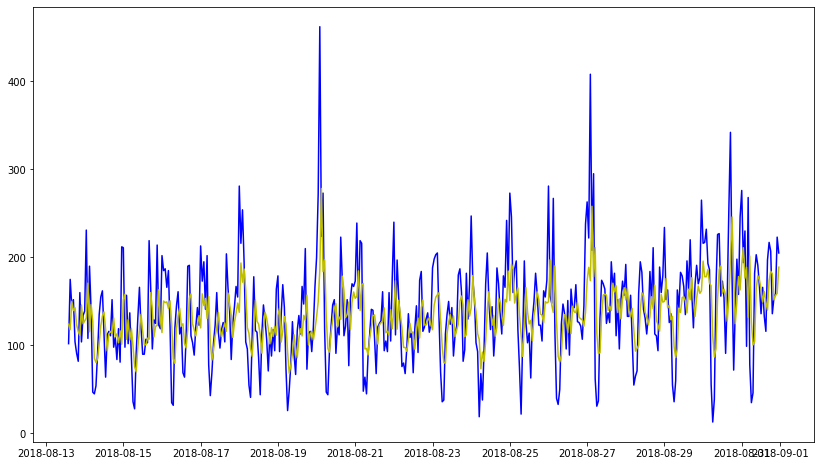

In [50]:
%%time

model = LinearRegression(normalize=True, fit_intercept=False)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)

print(f"RMSE модели на тесте: {mean_squared_error(target_test, target_predict) ** 0.5:.2f}")
print()
plt.figure(figsize = (14, 8))
plt.plot(target_test.index, target_test, 'b-', target_test.index, target_predict,'y-')

### RandomForestRegressor

RMSE модели на тесте: 47.65

CPU times: user 724 ms, sys: 12 ms, total: 736 ms
Wall time: 743 ms


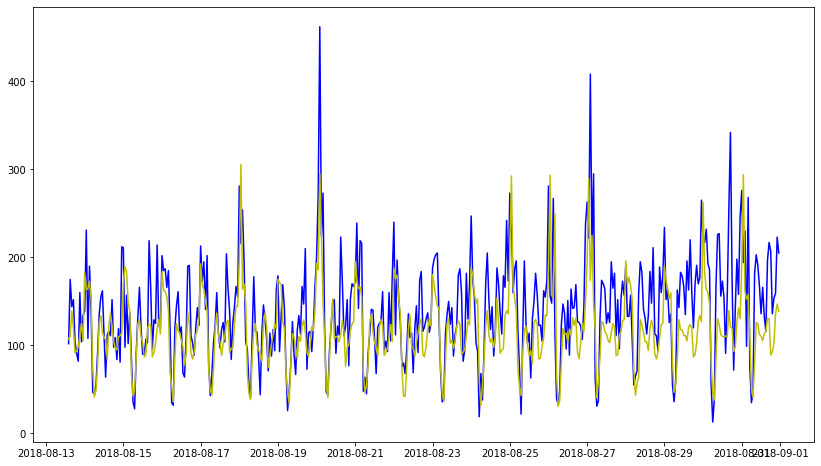

In [51]:
%%time

model = RandomForestRegressor(n_estimators = 50, max_depth = 13, random_state=12345)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)

print(f"RMSE модели на тесте: {mean_squared_error(target_test, target_predict) ** 0.5:.2f}")
print()
plt.figure(figsize = (14, 8))
plt.plot(target_test.index, target_test, 'b-', target_test.index, target_predict,'y-')

### LightGBM

RMSE модели на тесте: 46.56

CPU times: user 55.6 s, sys: 296 ms, total: 55.9 s
Wall time: 56.4 s


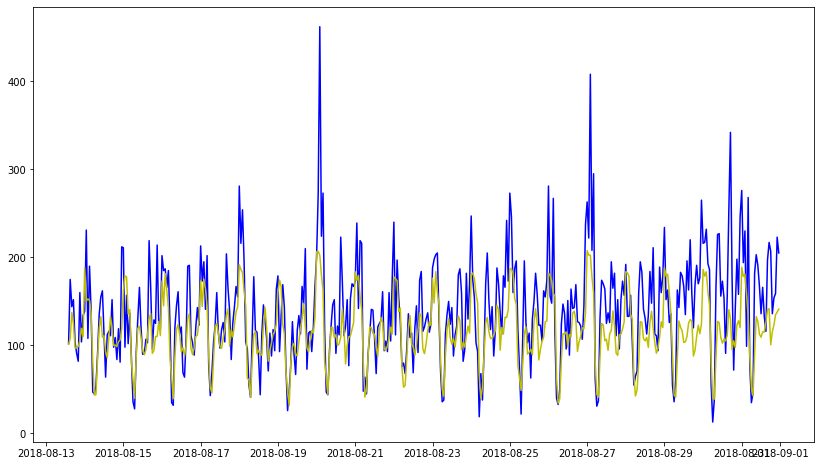

In [52]:
%%time

model = LGBMRegressor(num_leaves=21, n_estimators=500, learning_rate=0.01, random_state=12345)   
model.fit(features_train, target_train)
target_predict = model.predict(features_test)

print(f"RMSE модели на тесте: {mean_squared_error(target_test, target_predict) ** 0.5:.2f}")
print()
plt.figure(figsize = (14, 8))
plt.plot(target_test.index, target_test, 'b-', target_test.index, target_predict,'y-')

### CatBoost

0:	learn: 36.8558375	total: 1.3ms	remaining: 260ms
1:	learn: 35.3402750	total: 2.66ms	remaining: 263ms
2:	learn: 34.1274503	total: 3.91ms	remaining: 257ms
3:	learn: 32.9623433	total: 5.09ms	remaining: 250ms
4:	learn: 31.9890631	total: 6.23ms	remaining: 243ms
5:	learn: 31.1584984	total: 7.48ms	remaining: 242ms
6:	learn: 30.2589035	total: 8.7ms	remaining: 240ms
7:	learn: 29.6427799	total: 9.82ms	remaining: 236ms
8:	learn: 28.9708700	total: 11ms	remaining: 233ms
9:	learn: 28.3726145	total: 12.1ms	remaining: 230ms
10:	learn: 27.9660664	total: 13.3ms	remaining: 229ms
11:	learn: 27.4860234	total: 14.4ms	remaining: 225ms
12:	learn: 27.0877427	total: 15.5ms	remaining: 223ms
13:	learn: 26.8004010	total: 16.8ms	remaining: 223ms
14:	learn: 26.5602374	total: 17.9ms	remaining: 221ms
15:	learn: 26.2534409	total: 19ms	remaining: 219ms
16:	learn: 25.9640289	total: 20.1ms	remaining: 217ms
17:	learn: 25.7501494	total: 21.2ms	remaining: 214ms
18:	learn: 25.5039293	total: 22.3ms	remaining: 213ms
19:	learn

RMSE модели на тесте: 47.54

CPU times: user 255 ms, sys: 36.3 ms, total: 291 ms
Wall time: 1.03 s


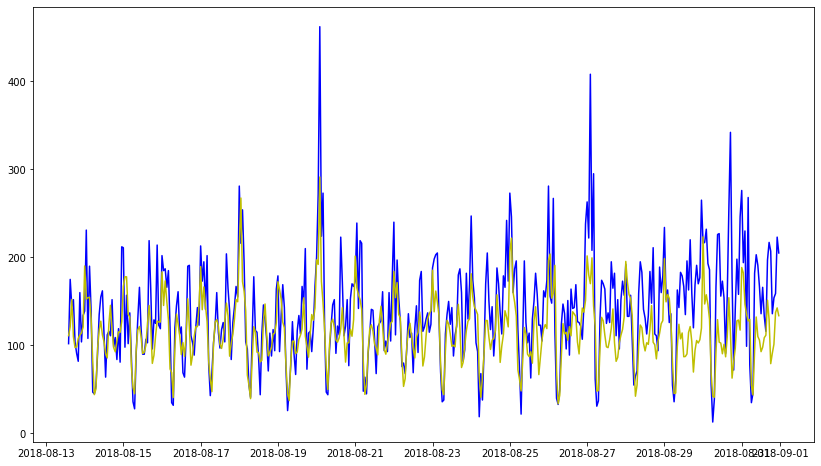

In [56]:
%%time

model = CatBoostRegressor(loss_function="RMSE", learning_rate = 0.1, iterations = 200)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)

print(f"RMSE модели на тесте: {mean_squared_error(target_test, target_predict) ** 0.5:.2f}")
print()
plt.figure(figsize = (14, 8))
plt.plot(target_test.index, target_test, 'b-', target_test.index, target_predict,'y-')

Вывод: 

- Проверка качества модели на тестовой выборке выявила недостатки - значение RMSE на тестовой выборке получилось значительно хуже у всех моделей
- Лучше всех справилась модель LightGBM, но при этом затраченное время у этой модели значительно превышает время обучения других моделей
- RandomForest и CatBoost показали допустимый результат в соотношении качество/затраченное время
- Судя по графикам, моделям хуже всего удается предсказывать последнюю треть временного ряда
- Предположу, что это связано с трендом роста количества заказов, который сильнее всего наблюдался в конце изучаемого временного ряда, как раз на нашей тестовой выборке. Поэтому модели не смогли точнее предсказать результат, обучившись на немного отличающемся наборе данных
